### **Multinomial Logistic Regression with scikit-learn**

Author: Nikos Papakostas   
Created: November 2024  
GitHub: https://github.com/papaknik  
LinkedIn: https://www.linkedin.com/in/nikos-papakostas/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings("always", category=ConvergenceWarning)
pd.set_option('max_colwidth', 38)
%load_ext watermark

In [2]:
%watermark

Last updated: 2024-12-02T19:38:35.771203+02:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



In [3]:
%watermark -v

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0



In [4]:
%watermark --iversions

matplotlib: 3.9.2
seaborn   : 0.13.2
IPython   : 8.27.0
pandas    : 2.2.2
numpy     : 1.26.4
sklearn   : 1.5.1



### Introduction

This practice project utilizes data extracted from the Open-Meteo Historical Weather API to construct a Multinomial Classification problem.   
The dataset contains numerical weather attributes as independent variables, and we aim to predict a categorical target variable named 'weather_event', which can take the following values:

    0: No precipitation
    1: Rain event
    2: Snowfall event  
    
The major challenge of this project is the complete lack of Domain Knowledge which is a key asset in any machine learning project.  
With limited time for subject research, I followed two simple steps:
1. Research similar machine learning tasks: I searched online for related ML projects to identify commonly used weather variables that could serve as predictors.
2. Logical reasoning: Before attempting to predict an event you first must be able to describe it. I considered how weather is usually described in forecasts, focusing on attributes like temperature, wind, humidity, and precipitation likelihood.

The dataset includes historical weather data from 2019 to 2023 for the center of Athens, Greece, and will serve as a practice set for multinomial classification. Our goal is to predict whether there will be no precipitation, rain, or snow at the specified location, utilizing Logistic Regression algorithm.   
In subsequent notebooks, we will explore different algorithms to tackle this problem.

**<u> Important note</u>**   
This project does not aim to replicate professional weather forecasting, where advanced numerical simulations and physical models are applied.   
These models rely on complex simulations of atmospheric processes and can predict future values for key weather variables over time, while in this project our predictive modeling will be based purely on historical data.

#### Dataset Description

- temperature_2m: Represents the air temperature measured at a height of 2 meters above the ground. This is a standard height for temperature observations in weather forecasting.

- relative_humidity_2m: Measures the percentage of moisture in the air relative to the maximum amount of moisture the air can hold at the same temperature.

- dew_point_2m: Indicates the temperature at which air becomes saturated with moisture and condensation begins, leading to the formation of dew, fog, or clouds.

- rain: This variable measures the precipitation from rain, typically expressed in millimeters (mm). It represents the amount of rainfall over a certain period (e.g., hourly). Higher values indicate heavier rainfall.

- snowfall: This variable records the amount of precipitation in the form of snow, also generally measured in millimeters (mm). Like rain, it provides insight into the accumulation of snow over time.

- surface_pressure: Refers to the atmospheric pressure exerted at the Earth's surface, typically measured in hectopascals (hPa). It is crucial for determining weather conditions like high and low-pressure systems.

- cloud_cover_low & cloud_cover_mid: Represents the percentage of the sky covered by low-level and mid-level clouds. Low clouds form close to the ground, while mid clouds occur higher up in the atmosphere.

- evapotranspiration: Reflects the combined process of water evaporation from the surface and transpiration from plants. It is used to estimate water loss in ecosystems.

- vapour_pressure_deficit: Represents the difference between the amount of moisture in the air and how much moisture the air can hold when it is saturated. It’s often used to assess plant water stress.

- wind_speed_10m: Measures the wind velocity at a height of 10 meters above the surface, which is the standard height for wind observations.

- wind_gusts_10m: Indicates the sudden, short-term increases in wind speed at 10 meters above the surface, which can impact weather severity.

- soil_temp_0_to_7cm: Measures the temperature of the soil in the top 7 cm layer, which is important for agriculture and assessing soil conditions.

- soil_moist_0_to_7cm: Reflects the water content in the top 7 cm of soil, important for understanding drought conditions and plant water availability.

- direct_radiation: Measures the amount of solar radiation received by the Earth’s surface directly from the sun, without scattering by clouds or the atmosphere. This is important for energy balance calculations.

Detailed information about the selected variables, as well as all available options, can be found **[here](https://open-meteo.com/en/docs/historical-forecast-api#start_date=2024-09-30).**

#### Scraping with Open-Meteo API 

Scraping data using the Open-Meteo Historical Forecast API is a simple process that can be completed in just a few steps.
First, ensure that the required Python `openmeteo_requests`, `requests_cache` and `retry_requests` modules are installed in your environment.   
If not, try running the following commands:   
`pip install openmeteo_requests`   
`pip install requests_cache` and   
`pip install retry_requests`   

Once the modules are installed, follow these steps:

- <u>Navigate to the Open-Meteo Historical Weather API documentation, **[here](https://open-meteo.com/en/docs/historical-forecast-api#start_date=2024-09-30)</u>**
- Select the coordinates of the desired location (e.g., a city or a specific latitude and longitude).
- Choose the time interval by setting the Start Date and End Date.
- Pick the parameters (e.g., temperature, precipitation, wind speed) that you are interested in.

The API will generate a Python code snippet for you. Copy and paste this snippet into your notebook or script, and you are all set to start scraping data!

**You can skip the following step and use directly the extracted csv file that can be found in the `/data` folder of the repository in [GitHub](https://github.com/papaknik/Multinomial-Logistic-Regression-with-scikit-learn).**

In [5]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 37.9838,
	"longitude": 23.7278,
	"start_date": "2019-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "rain", "snowfall", 
               "surface_pressure", "cloud_cover_low", "cloud_cover_mid", "et0_fao_evapotranspiration", 
               "vapour_pressure_deficit", "wind_speed_10m", "wind_gusts_10m", "soil_temperature_0_to_7cm", 
               "soil_moisture_0_to_7cm", "direct_radiation"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(5).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(7).ValuesAsNumpy()
hourly_et0_fao_evapotranspiration = hourly.Variables(8).ValuesAsNumpy()
hourly_vapour_pressure_deficit = hourly.Variables(9).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(10).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(11).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(12).ValuesAsNumpy()
hourly_soil_moisture_0_to_7cm = hourly.Variables(13).ValuesAsNumpy()
hourly_direct_radiation = hourly.Variables(14).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["evapotranspiration"] = hourly_et0_fao_evapotranspiration
hourly_data["vapour_pressure_deficit"] = hourly_vapour_pressure_deficit
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["soil_temp_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
hourly_data["soil_moist_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
hourly_data["direct_radiation"] = hourly_direct_radiation

df = pd.DataFrame(data = hourly_data)
df.info()

Coordinates 37.996482849121094°N 23.70967674255371°E
Elevation 92.0 m asl
Timezone b'Europe/Athens' b'EEST'
Timezone difference to GMT+0 10800 s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   date                     43824 non-null  datetime64[ns, UTC]
 1   temperature_2m           43824 non-null  float32            
 2   relative_humidity_2m     43824 non-null  float32            
 3   dew_point_2m             43824 non-null  float32            
 4   rain                     43824 non-null  float32            
 5   snowfall                 43824 non-null  float32            
 6   surface_pressure         43824 non-null  float32            
 7   cloud_cover_low          43824 non-null  float32            
 8   cloud_cover_mid          43824 non-null  float32            
 9   evapotranspirat

#### Creating the multiclass target variable

The first step is to create the target variable 'weather_event' for our multi-class classification problem.   
We create a new column called 'weather_event' with the following rules:

    0: When both the 'rain' and 'snowfall' variables are 0 (indicating no precipitation).
    1: When the 'rain' variable is greater than 0 and the 'snowfall' variable is 0 (indicating a rain event).
    2: When the 'snowfall' variable is greater than 0 and the 'rain' variable is 0 (indicating a snowfall event).

Occasionally, there are some rare instances over the 5-year period where both rain and snowfall occurred within the same hour. In these cases, we assign to 'weather_event', the value based on which variable has the higher precipitation (rain or snowfall), ensuring that the most significant weather event is captured.

In [6]:
# Define the conditions
conditions = [
    (df['rain'] > 0) & (df['snowfall'] > 0),   # Both rain and snowfall
    (df['rain'] > 0) & (df['snowfall'] == 0),  # Only rain
    (df['snowfall'] > 0) & (df['rain'] == 0)   # Only snowfall
]

# Define the values for each condition
values = [
    np.where(df['rain'] > df['snowfall'], 1, 2),  # Choose rain if higher, otherwise snowfall
    1,  # Only rain
    2   # Only snowfall
]

# Use np.select to create the 'weather_event' column
df['weather_event'] = np.select(conditions, values, default=0)  # Default is 0 for no precipitation

Removing the columns 'rain' and 'snowfall' since they are no longer needed after the creation of the target variable

In [7]:
df = df.drop(columns=['rain', 'snowfall'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   date                     43824 non-null  datetime64[ns, UTC]
 1   temperature_2m           43824 non-null  float32            
 2   relative_humidity_2m     43824 non-null  float32            
 3   dew_point_2m             43824 non-null  float32            
 4   surface_pressure         43824 non-null  float32            
 5   cloud_cover_low          43824 non-null  float32            
 6   cloud_cover_mid          43824 non-null  float32            
 7   evapotranspiration       43824 non-null  float32            
 8   vapour_pressure_deficit  43824 non-null  float32            
 9   wind_speed_10m           43824 non-null  float32            
 10  wind_gusts_10m           43824 non-null  float32            
 11  soil_temp_0_to_7cm       438

#### Adding a time related variable in the dataset

Everyone knows from life experience that weather is closely tied to seasons, meaning that the likelihood of a 'snowfall' event is much higher during winter months, or that the likelihood of 'rain' is expected to be lower during the months of July and August *(at least up to most recent years...)*.   
Considering this, the addition of the month as a numerical variable (ranging from 1 to 12), can be a valuable addition to the dataset, and we expect it to have significant predictive power in the models we build.

In [9]:
df['month'] = df['date'].dt.month

At this point you can save the extracted DataFrame to a csv file.

In [10]:
athens_weather_df_2019_2023 = df.to_csv('data/athens_weather_df_2019_2023.csv', index=False)

**If you wish to skip the steps of downloading the data from the API, you can simply load the pre-saved dataset directly from the CSV file, available in the 'data' folder of this project's GitHub repository.**

In [5]:
df = pd.read_csv('data/athens_weather_df_2019_2023.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     43824 non-null  object 
 1   temperature_2m           43824 non-null  float64
 2   relative_humidity_2m     43824 non-null  float64
 3   dew_point_2m             43824 non-null  float64
 4   surface_pressure         43824 non-null  float64
 5   cloud_cover_low          43824 non-null  float64
 6   cloud_cover_mid          43824 non-null  float64
 7   evapotranspiration       43824 non-null  float64
 8   vapour_pressure_deficit  43824 non-null  float64
 9   wind_speed_10m           43824 non-null  float64
 10  wind_gusts_10m           43824 non-null  float64
 11  soil_temp_0_to_7cm       43824 non-null  float64
 12  soil_moist_0_to_7cm      43824 non-null  float64
 13  direct_radiation         43824 non-null  float64
 14  weather_event         

#### Creating Lagged Variables for Predictive Modeling

Predicting current weather using present data isn’t true forecasting.   
To make this project more realistic and challenging, we will introduce lagged variables.   
Specifically, to predict whether it will rain, snow, or not at a given `time point t`, we will use weather parameters from one hour earlier (`time point t-1`). This approach enables us to predict future weather conditions based on past observations, simulating the use of historical data.   
The addition of lagged variables makes the project more challenging and adds a touch of realism, while at the same time we can still practice with ML classification algorithms 

Feel free to experiment and alter the data to your liking.   
Instead of using the previous hour's weather attributes, you can use the values from the past 3 hours, or even compile a moving average value, for example an average of the past 3 hours where you average the values of each predictor for the time points t-3, t-2 and t-1, in order to predict the 'weather_event' attribute at time point t.

In [7]:
# List of columns for which to create lag variables
lag_columns = ["temperature_2m", 
    "relative_humidity_2m", 
    "dew_point_2m", 
    "surface_pressure", 
    "cloud_cover_low", 
    "cloud_cover_mid", 
    "evapotranspiration", 
    "vapour_pressure_deficit", 
    "wind_speed_10m", 
    "wind_gusts_10m", 
    "soil_temp_0_to_7cm", 
    "soil_moist_0_to_7cm", 
    "direct_radiation",
    "month"
]

# Create a new DataFrame to store the lagged features
lagged_1h_df = df.copy()  # Copy the original DataFrame to modify it

# Create 1-hour lagged features
for col in lag_columns:
    lagged_1h_df[f'{col}_lag_1h'] = df[col].shift(1)  # Shift by 1 step (1 hour back in the data)

# Drop rows with NaN values (if any), that result from the lagging process
lagged_1h_df = lagged_1h_df.dropna(subset=[f'{col}_lag_1h' for col in lag_columns])

# Drop the current-time columns to keep only the lagged versions
lagged_1h_df = lagged_1h_df.drop(columns=lag_columns)

In [8]:
lagged_1h_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43823 entries, 1 to 43823
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            43823 non-null  object 
 1   weather_event                   43823 non-null  int64  
 2   temperature_2m_lag_1h           43823 non-null  float64
 3   relative_humidity_2m_lag_1h     43823 non-null  float64
 4   dew_point_2m_lag_1h             43823 non-null  float64
 5   surface_pressure_lag_1h         43823 non-null  float64
 6   cloud_cover_low_lag_1h          43823 non-null  float64
 7   cloud_cover_mid_lag_1h          43823 non-null  float64
 8   evapotranspiration_lag_1h       43823 non-null  float64
 9   vapour_pressure_deficit_lag_1h  43823 non-null  float64
 10  wind_speed_10m_lag_1h           43823 non-null  float64
 11  wind_gusts_10m_lag_1h           43823 non-null  float64
 12  soil_temp_0_to_7cm_lag_1h       43823

### Basic Exploratory Data Analysis

- descriptive statistics of the DataFrame

In [9]:
lagged_1h_df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
weather_event,43823.0,0.09,0.29,0.00,0.00,0.00,0.00,2.00
temperature_2m_lag_1h,43823.0,18.24,7.93,-2.19,12.21,17.56,24.26,43.81
relative_humidity_2m_lag_1h,43823.0,62.36,18.49,8.38,48.58,64.57,77.69,100.00
dew_point_2m_lag_1h,43823.0,10.00,5.22,-11.04,6.76,10.41,13.76,23.36
surface_pressure_lag_1h,43823.0,1004.17,5.83,973.40,1000.32,1003.65,1007.60,1028.19
cloud_cover_low_lag_1h,43823.0,10.38,23.18,0.00,0.00,0.00,6.00,100.00
cloud_cover_mid_lag_1h,43823.0,14.50,27.04,0.00,0.00,0.00,15.00,100.00
evapotranspiration_lag_1h,43823.0,0.16,0.20,0.00,0.01,0.05,0.24,0.97
vapour_pressure_deficit_lag_1h,43823.0,1.04,0.99,0.00,0.32,0.66,1.45,8.26
wind_speed_10m_lag_1h,43823.0,9.26,5.24,0.00,5.45,8.40,12.14,42.49


From the above descriptive statistics, it is clear that the dataset contains features with vastly different units and scales. Attributes such as temperature, pressure, and wind speed inherently have different ranges and variances.   
Without scaling, features with larger values may disproportionately influence the model, leading to biased or incorrect results.   
Scaling the data ensures that all features contribute equally to the learning process, allowing the model to consider each feature evenly.   
Therefore, it is crucial to scale the data before proceeding with any modeling.

- checking class balance of the target variable `weather_event`

weather_event
0    40083
1     3677
2       63
Name: count, dtype: int64
weather_event
0    91.465669
1     8.390571
2     0.143760
Name: proportion, dtype: float64


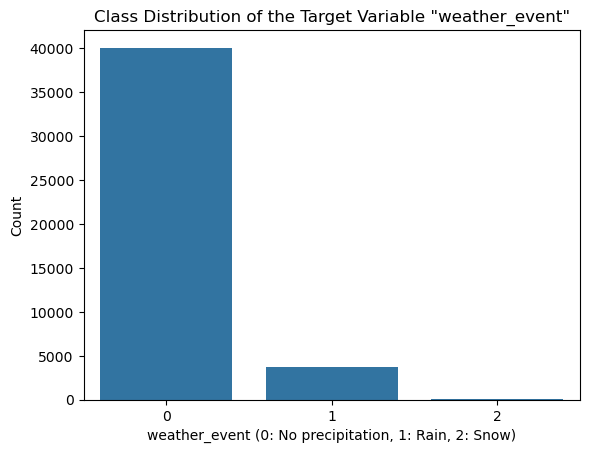

In [10]:
# Checking the class distribution of the target variable 'rain'
class_counts = lagged_1h_df['weather_event'].value_counts()
print(class_counts)

# To see the percentage distribution:
class_percentages = lagged_1h_df['weather_event'].value_counts(normalize=True) * 100
print(class_percentages)

sns.countplot(x='weather_event', data=lagged_1h_df)
plt.title('Class Distribution of the Target Variable "weather_event"')
plt.xlabel('weather_event (0: No precipitation, 1: Rain, 2: Snow)')
plt.ylabel('Count')
plt.show();

The dataset is **severely imbalanced**, with approximately 91.5% of the records representing “no precipitation" events, 8.4% for "rain" events, and only 0.1% for "snowfall" events. This class imbalance is likely to affect the model's performance, as it may become biased toward predicting the majority class (no precipitation) during training.   
To address this issue, an oversampling technique such as SMOTE (Synthetic Minority Over-sampling Technique) should be applied to ensure that the model can learn from the minority classes effectively.   
Additionally, when evaluating the model's performance, we need to focus on metrics like precision, recall and f1-score than relying on accuracy which can lead us to misleading conclusions. 
In our dataset for example, a 'dummy' model that always predicts 0, might achieve a high accuracy of 91.5%, but would completely fail in predicting rain or snowfall events, which was the purpose it was built for.

- checking for duplicated records

In [11]:
lagged_1h_df.duplicated().sum()

0

- checking for missing values

When preparing data for modeling with scikit-learn, it's crucial to ensure there are no missing (null) values, as most algorithms in scikit-learn cannot handle them. If missing values are present, the model will fail to execute. To handle this, you can use techniques like imputation (e.g., replacing missing values with the median or more advanced techniques).   
If the dataset is large enough and the missing values are minimal, removing these records can also be an option, as long as the data's <u>distributions are not distorted.</u>   
You can find useful information about missing data imputation in the **[official documentation](https://scikit-learn.org/stable/modules/impute.html)** of scikit-learn library.

In [12]:
lagged_1h_df.isna().sum()

date                              0
weather_event                     0
temperature_2m_lag_1h             0
relative_humidity_2m_lag_1h       0
dew_point_2m_lag_1h               0
surface_pressure_lag_1h           0
cloud_cover_low_lag_1h            0
cloud_cover_mid_lag_1h            0
evapotranspiration_lag_1h         0
vapour_pressure_deficit_lag_1h    0
wind_speed_10m_lag_1h             0
wind_gusts_10m_lag_1h             0
soil_temp_0_to_7cm_lag_1h         0
soil_moist_0_to_7cm_lag_1h        0
direct_radiation_lag_1h           0
month_lag_1h                      0
dtype: int64

- checking linear relations between variables using a correlation matrix heatmap

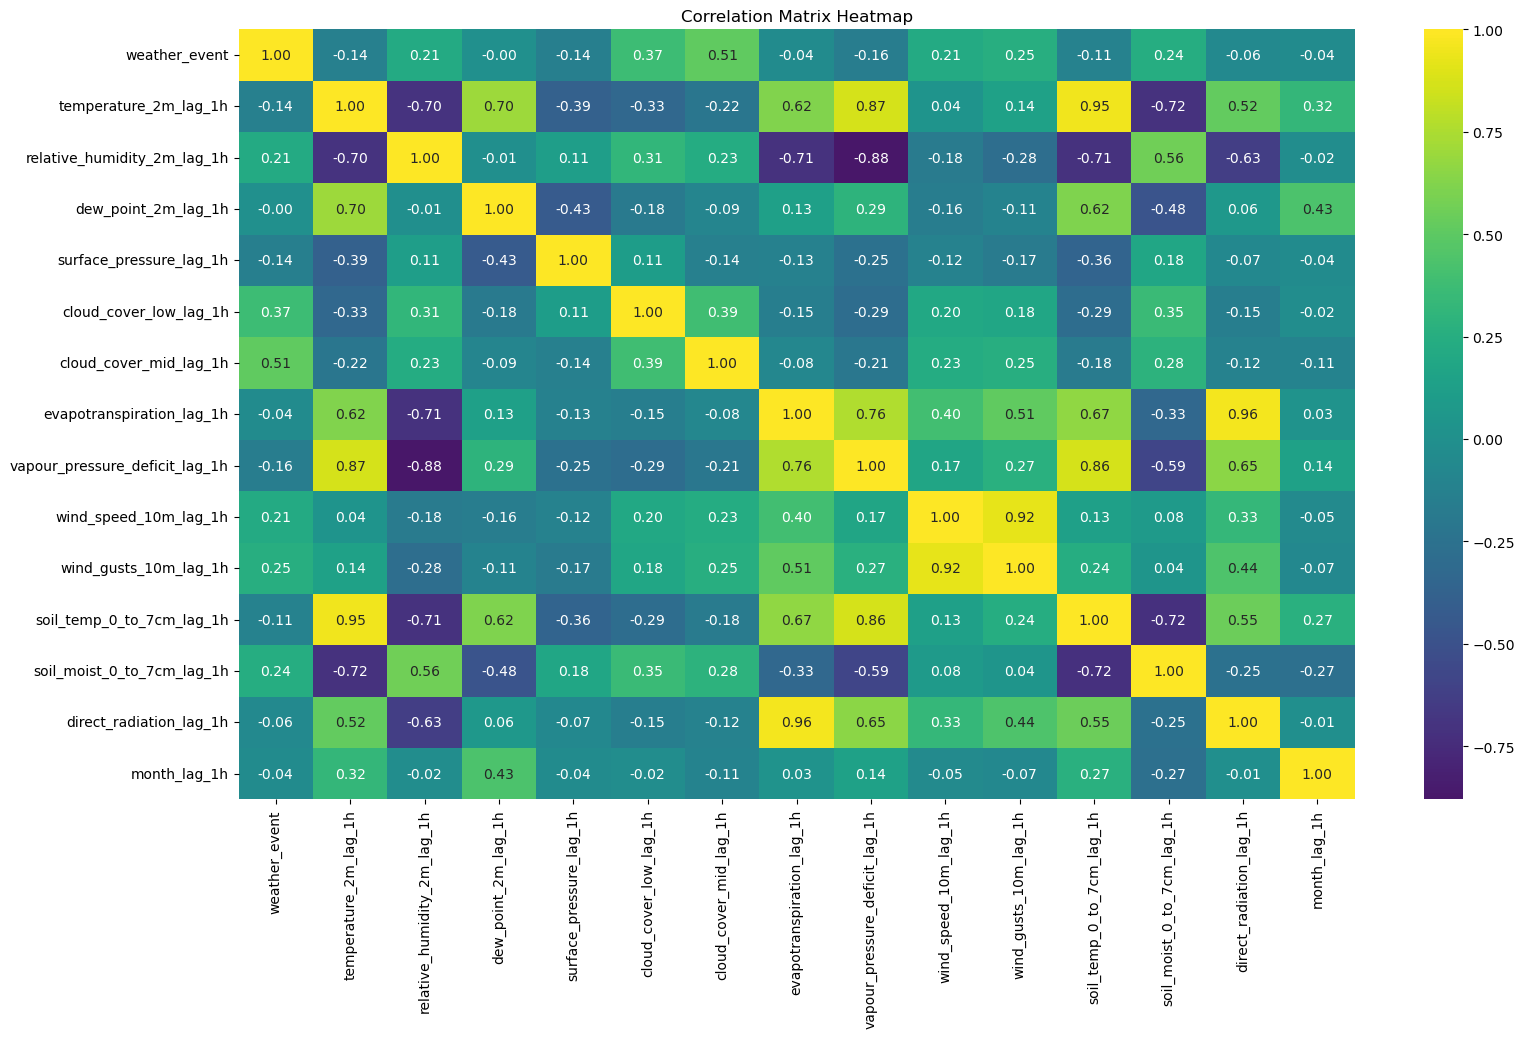

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = lagged_1h_df.corr(numeric_only = True, method = 'pearson')

# Create the heatmap
figure = plt.figure(figsize=(18, 10));
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', center=0)

# Add a title
title = plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

There are several strong correlations among the variables, with values well above 0.75. Some pairs of variables show correlations as high as -0.88, 0.92, or even 0.96!

#### Addressing the issue of multicollinearity

One common approach when dealing with strongly correlated variables is to remove one variable from each highly correlated pair—the one that proves to be less contributive to the model's outcome.   
This can be based on the variables/features contribution to the model's performance, which can only be evaluated after modeling.   
So, in this case rerunning the model is necessary to assess the impact on performance after each variable removal, making this an iterative process that requires time and patience.

An alternative approach is Principal Component Analysis (PCA), a technique used to reduce the dimensionality of the dataset and handle multicollinearity. PCA transforms correlated variables into uncorrelated principal components. However, the downside of this technique is that while it effectively addresses multicollinearity, it results in a model that is difficult to interpret. Since the transformed components do not correspond directly to the original features, and thus the concept of feature importance becomes less useful in cases, interpretability is important. 

Feature engineering and Interaction Terms is another approach, but it definitely demands Domain knowledge and experience on this particular field, so this is not an option for us also.   

What remains as an option to handle the issue of collinearity and multicollinearity is Regularization.   
Specifically, using L2 Regularization penalty in Logistic Regression class allows us to keep all variables, even if they are highly correlated, by shrinking their coefficients.   
This addresses multicollinearity (*to an extent*), without losing interpretability while at the same time it helps control overfitting and provides a more balanced model without removing critical features or transforming them into less interpretable forms.   
The good news is that the `LogisticRegression()` class of scikit-learn, uses by default for the penalty argument the l2 term and therefore we will leave multicollinearity to be handled (to an extent of course) internally by the algorithm.

Therefore, we will retain all features in our dataset and let the algorithm mitigate the effects of multicollinearity during the modeling process.

- plotting predictor distributions

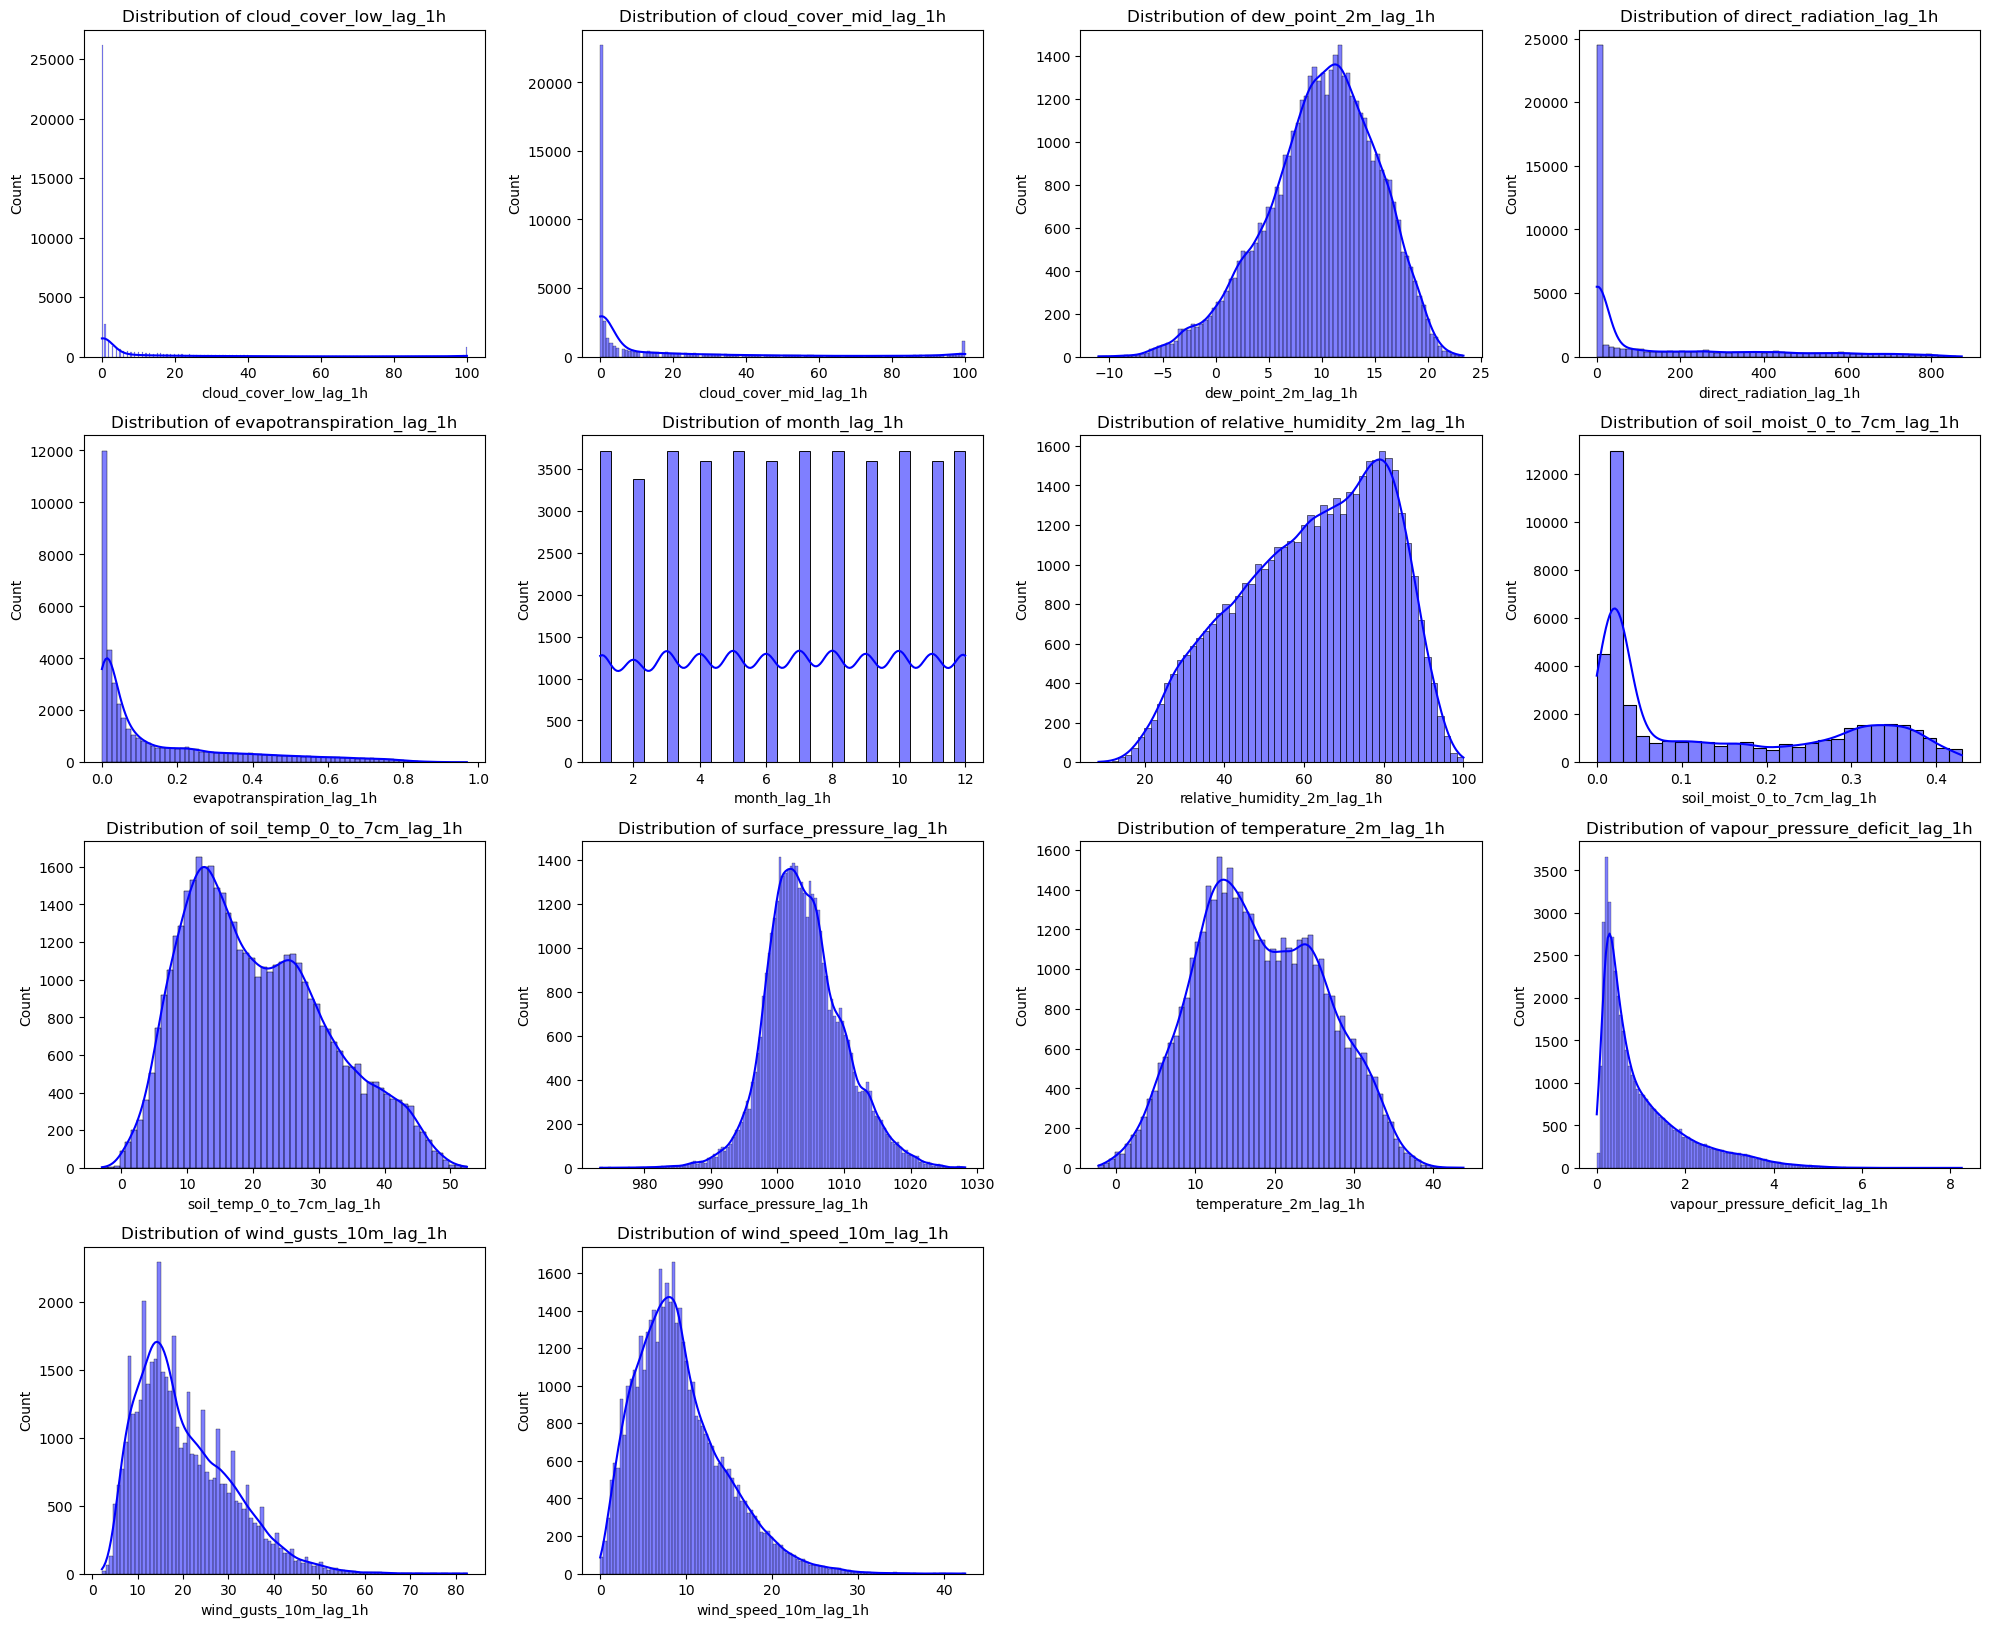

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to plot
columns_to_plot = lagged_1h_df.columns.difference(['date', 'weather_event'])

figure = plt.figure(figsize=(20, 20))  # Adjusted for better spacing

# Loop through each column and create a distribution (histogram)
for i, col in enumerate(columns_to_plot, start=1):
    subplot = plt.subplot(len(columns_to_plot)//3 + 1, 4, i)
    histplot = sns.histplot(lagged_1h_df[col], kde=True, color='blue')
    
    title = plt.title(f'Distribution of {col}', fontsize=12) 

# Adjust the layout for better visual spacing
layout = plt.tight_layout()
plt.show()

From the distribution plots there are several conclusions we can derive, such as:
- 'surface_pressure' and 'dew_point_2m' display more symmetrical distributions, suggesting that the values for these variables are distributed more evenly around a central point. They can be well approximated from the normal distribution and therefore easier to predict
- 'evapotranspiration' and 'vapour_pressure' are highly right-skewed. This means that most of their values are concentrated close to 0, indicating that extreme values to the right tail are rare, and most likely will be indicated as outliers
- the values in features like 'relative_humidity' and 'wind_gusts' are spread across a wider range, which could imply that these features fluctuate significantly over time
- just like spotted in the descriptive statistics table, the varying scales of some distributions (some are tightly concentrated around a single value, while others are spread out over a large range) are evident, and therefore it is crucial to use scaling methods like `RobustScaler` or `StandardScaler` before applying machine learning algorithms, to prevent certain features from dominating due to their wider range.

#### Feature Transformation

In cases where variables deviate significantly from a Gaussian distribution, particularly those with high positive skewness or heavily tailed (high kurtosis), it may be necessary to apply a transformation to approximate normality.   

Many machine learning models and statistical techniques assume normality, as variables with a Gaussian-like distribution can lead (but not guarantee) to better model performance and more reliable inferences. The Yeo-Johnson transformation is one such method, particularly useful for handling variables that include zero or negative values. Unlike the logarithmic and square root transformations, which are constrained to non-negative values, Yeo-Johnson can be applied to this range of values, making it a valuable transformation tool.   

However, the effectiveness of this or any transformation is not guaranteed and may not improve the model's performance.   
The process is iterative: you apply the transformation, evaluate the results, and reassess if needed.   

Apart from observing visually the predictors distributions you can approach the task numerically and spot the variables that need a transformation and lead to a potential increase of the model’s performance by computing the skewness and kurtosis of each predictor variable.   
If the values for these statistics exceed a certain threshold, then the predictor can be a serious candidate for transformation.
A general rule of thumb is that a Kurtosis value above 4 captures heavy-tailed variables and a Skewness value above or below ±1 captures significantly asymmetric variables. These are the values we will also use as the threshold to spot the predictors in the data set that need further processing through Yeo-Johnson transformation.

In [15]:
from scipy.stats import skew, kurtosis

# Step 1: Filter numeric columns
numeric_cols = lagged_1h_df.select_dtypes(include=['float64'])  

# Step 2: Set thresholds
skew_threshold = 1
kurt_threshold = 4

# Step 3: Calculate skewness and kurtosis for numeric columns
skewness = numeric_cols.apply(lambda col: skew(col.dropna()), axis=0)  # Drop NA to avoid errors
kurt = numeric_cols.apply(lambda col: kurtosis(col.dropna()), axis=0)

# Step 4: Identify variables exceeding thresholds
skewed_cols = skewness[abs(skewness) > skew_threshold].index.tolist()
high_kurt_cols = kurt[kurt > kurt_threshold].index.tolist()

# Step 5: Combine results
variables_to_transform = list(set(skewed_cols + high_kurt_cols))

# Display results
print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurt)
print("\nVariables to consider for transformation:\n", variables_to_transform)

Skewness:
 temperature_2m_lag_1h             0.150348
relative_humidity_2m_lag_1h      -0.364587
dew_point_2m_lag_1h              -0.433332
surface_pressure_lag_1h           0.271628
cloud_cover_low_lag_1h            2.679562
cloud_cover_mid_lag_1h            2.087584
evapotranspiration_lag_1h         1.476544
vapour_pressure_deficit_lag_1h    1.603295
wind_speed_10m_lag_1h             0.933306
wind_gusts_10m_lag_1h             0.919183
soil_temp_0_to_7cm_lag_1h         0.491397
soil_moist_0_to_7cm_lag_1h        0.541617
direct_radiation_lag_1h           1.432146
month_lag_1h                     -0.009510
dtype: float64

Kurtosis:
 temperature_2m_lag_1h            -0.675835
relative_humidity_2m_lag_1h      -0.785772
dew_point_2m_lag_1h              -0.028103
surface_pressure_lag_1h           0.730412
cloud_cover_low_lag_1h            6.387977
cloud_cover_mid_lag_1h            3.240495
evapotranspiration_lag_1h         1.235104
vapour_pressure_deficit_lag_1h    2.491644
wind_speed_10m_l

#### Exploring predictor variable distributions across target classes

Another essential and insightful step is to check how predictors behave across different classes of the target variable.   
This step allows us to identify patterns and understand the relationship between predictors and the target classes (no precipitation, rain, snowfall).   
Detecting any significant variation (shape and value counts across classes) in distributions might indicate that a variable could be an important predictor for the occurrence of a class, while similar distributions across classes could suggest a variable with less predictive power.

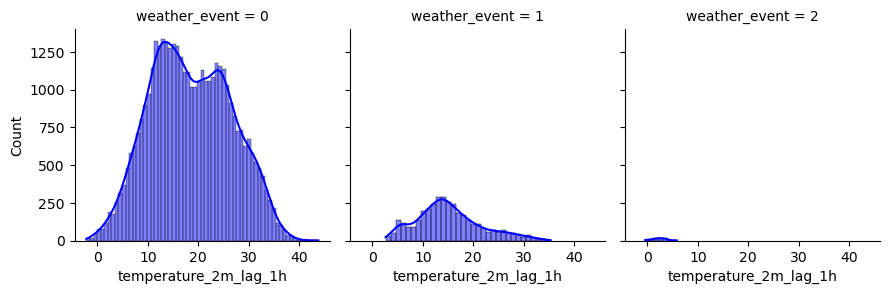

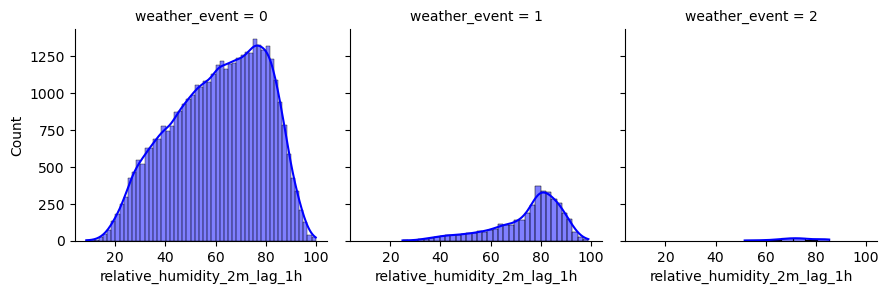

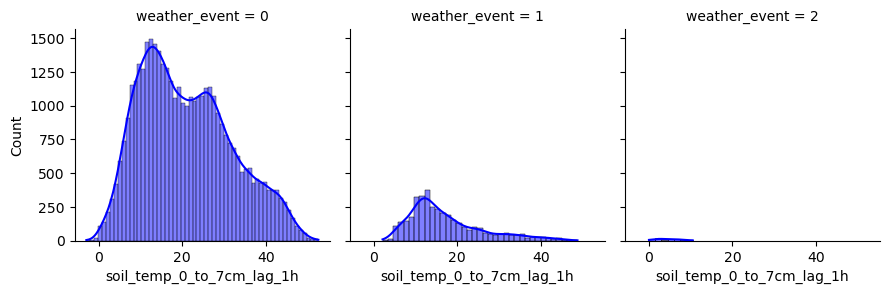

In [16]:
g1 = sns.FacetGrid(lagged_1h_df, col="weather_event", col_wrap=3, height=3)
map1 = g1.map(sns.histplot, "temperature_2m_lag_1h", kde=True, color="blue")  
subplot1 = g1.fig.subplots_adjust(top=0.9)  

g2 = sns.FacetGrid(lagged_1h_df, col="weather_event", col_wrap=3, height=3)
map2 = g2.map(sns.histplot, "relative_humidity_2m_lag_1h", kde=True, color="blue")  
subplot2 = g2.fig.subplots_adjust(top=0.9) 

g3 = sns.FacetGrid(lagged_1h_df, col="weather_event", col_wrap=3, height=3)
map3 = g3.map(sns.histplot, "soil_temp_0_to_7cm_lag_1h", kde=True, color="blue")  
subplot3 = g3.fig.subplots_adjust(top=0.9) 

plt.show()

- detecting outliers

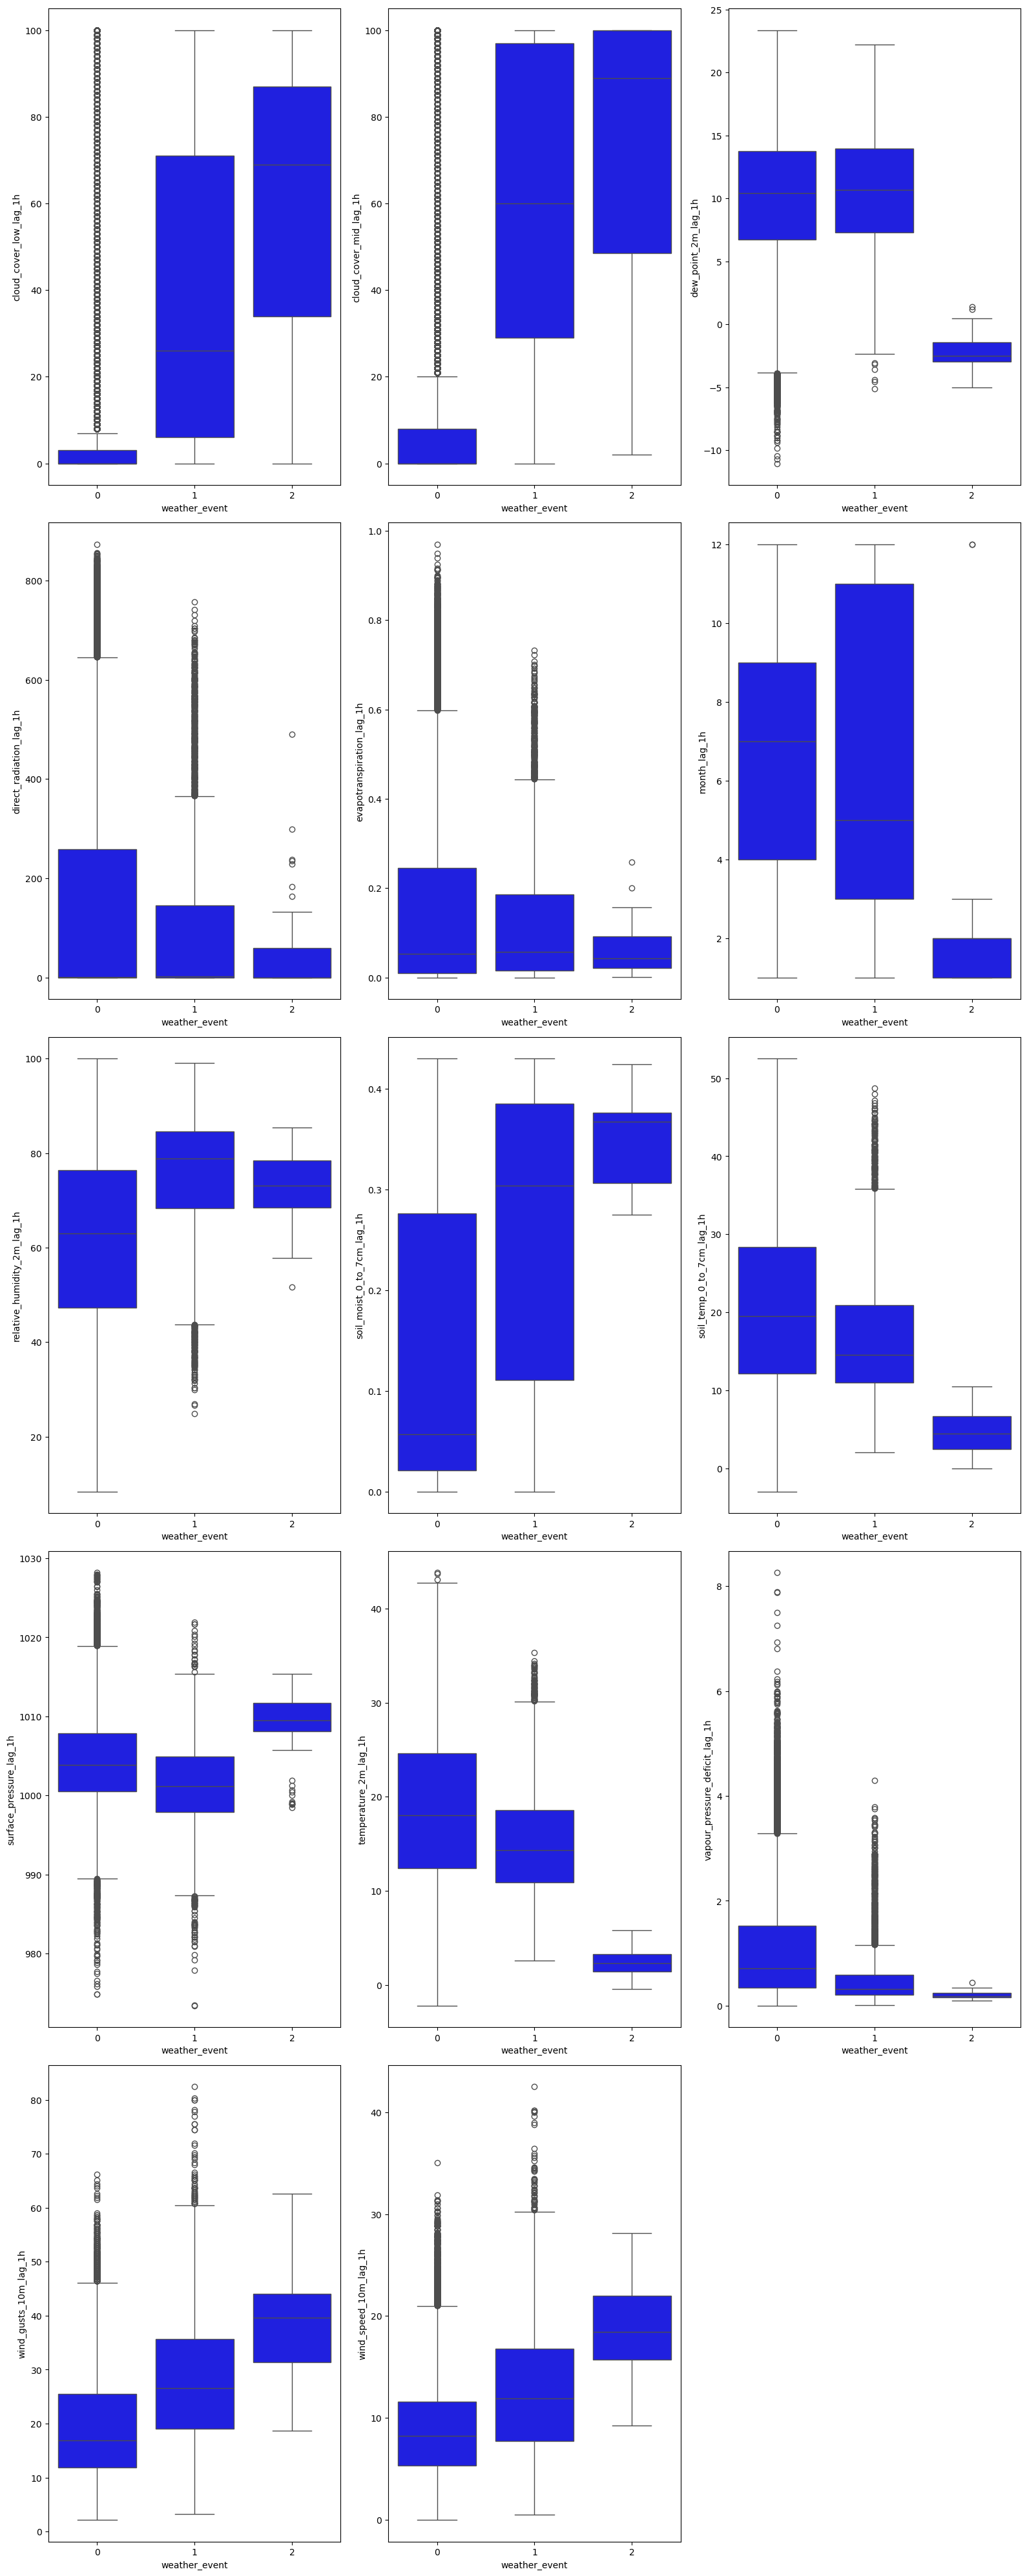

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to plot
columns_to_plot = lagged_1h_df.columns.difference(['date', 'weather_event'])

figure = plt.figure(figsize=(16, 40))

# Loop through each column and create a boxplot with weather_event grouping
for i, col in enumerate(columns_to_plot, start=1):
    subplot = plt.subplot(len(columns_to_plot)//3 + 1, 3, i)  # Define a 3-column layout
    boxplot = sns.boxplot(data=lagged_1h_df, x='weather_event', y=col, color='blue')  # Grouped by weather_event

# Adjust the layout
layout = plt.tight_layout()
plt.show()

Viewing the above box plots makes the presence of outliers more than obvious.
Whether these values represent measurement errors, anomalies, or valid extreme observations is uncertain.

With the **lack of fundamental domain knowledge**, access to the instruments used for the measurements, or the procedures followed, makes any kind of inference on the outliers impossible and arbitrarily removing or modifying them inserts more uncertainty in the project.

For this reason, it is better to retain all records, since even a simple action like removing the outliers is very likely to distort the distributions, insert more uncertainty in the project, introducing bias to the modeling process and alter the model's performance to unknown directions.   
We will try to mitigate their effect by using tools like robust scaling and Yeo-Johnson transformations.

## Modeling process

During modeling phase the metric that will be used to evaluate the performance of the models as well as to facilitate the comparison between them is `balanced accuracy`.  

Balanced accuracy is the average of the recall (sensitivity) for each class, treating each class equally regardless of its frequency.   
Unlike standard accuracy, which in imbalanced datasets is biased towards the majority class and gives a false impression about the model's performance, balanced accuracy metric provides a more fair view of how well the model performs across all classes and illustrate the overall model performance.

For a heavily imbalanced dataset, balanced accuracy will prevent the majority class from dominating the metric, allowing us to see if the model truly performs well on the minority classes, and not only on the majority class.

You can find detailed information on evaluation metrics used for both classification and regression tasks in the **[official documentation](https://scikit-learn.org/1.5/modules/model_evaluation.html)**

#### Logistic Regression Essentials

Multinomial Logistic Regression is a classification algorithm used when the target variable is categorical and has more than two possible classes.   
Unlike binary logistic regression, which uses the sigmoid function, multinomial logistic regression uses the softmax function to compute the probability of each class.   

In multinomial logistic regression, we model the probability of a data point belonging to one of multiple possible classes. For example, we might predict weather conditions such as "No Precipitation," "Rain," or "Snowfall."   
In scikit-learn, multinomial logistic regression by default outputs a predicted class y for each data point, selecting the class with the highest probability. 

How the Algorithm Works:

**Input Features and Coefficients:**   
The model takes the input features (independent variables, X) and initializes a vector of coefficients (β) for each class.   
These coefficients are initially set to small random values or zeros and will be adjusted during the training process by the solver (the optimization algorithm). 

**Understanding Logits (Log Odds):**   
In logistic regression, a core concept is the logit, also known as the log odds and represents a way of expressing probabilities.   
For a given class k, the odds are defined as the ratio of the probability of that class occurring to the probability of it not occurring:   
    $$
\text{odds}_k = \frac{P(y = y_k \mid X)}{1 - P(y = y_k \mid X)}
    $$

And consequently, for a given class k, the logit is defined as the natural logarithm of the odds of that class occurring.     
This transformation maps probabilities (which range from 0 to 1) to logits (which range from −∞ to +∞), making it possible to create a linear relationship between the input features and the predicted outcome y.

**Logit Calculation:**   
For each class k, the logit is computed as a linear combination of the input features and their corresponding coefficients:   
    $$
\text{logit}_k = \beta_{0,k} + \beta_{1,k} x_1 + \beta_{2,k} x_2 + \dots + \beta_{n,k} x_n
    $$

The model calculates a logit for each class, and this is the raw score before probabilities are computed. Applying this and you end up in our project with 3 logits for every record in your dataset. (1 logit for the 'no precipitation class/label, 1 logit for the 'rain' class/label and 1 logit for the 'snowfall' class/label) 

**Softmax Transformation:**   
The logits are then passed through the softmax function, which converts them into probabilities for each class.   
The softmax function also ensures that all probabilities are between 0 and 1, and that the total probability across all classes equals 1:   
    $$
   P(y = k \mid X) = \frac{\exp(\text{logit}_k)}{\sum_{j=1}^{K} \exp(\text{logit}_j)}
    $$
So after the Softmax transformation every record in the dataset has been assigned with a probability for each class.   
In our case the model predicts whether there will be 'No Precipitation', 'Rain', or 'Snowfall', and it calculates three logits (one for each class). These logits are then transformed into probabilities using the softmax function and the model assigns the class with the highest probability to the target variable y.   
For example, a record in our dataset could end up having the following probabilities:
   - No Precipitation: 0.60   
   - Rain: 0.30   
   - Snowfall: 0.10
   
Then the model would predict the class 'No Precipitation' for the target variable y, since it has the highest probability.

**Loss/Error Function (Cross-Entropy):**   

The cross-entropy loss function measures the error between the predicted probabilities and the true class labels. It’s calculated as:   
    $$
   L = - \sum_{k=1}^{K} y_k \log \left( P(y = k \mid X) \right)
    $$   

This loss is used as feedback to the model. The closer the predicted probability is to the true label, the smaller the loss.   
To make it more concrete we will use the above example where the model predicted 'No precipitation' and suppose that the true label was 'rain'.   
In this example, since the true label is Rain, we have $y_{\text{rain}}=1$, and for the other classes, $y_{\text{no precipitation}}=0$ and $y_{\text{snowfall}}=0$.   

Applying the formula of the loss function shown above, and considering only the probability for the correct class (Rain), as the other terms will be multiplied by 0, we have: $L = -(1 \times \log(0.30)) - (0 \times \log(0.60)) - (0 \times \log(0.10))$ which leads to:   $L = -\log(0.30) \approx -(-0.523) = 0.523$.   
This is the loss for this particular record (0.523).


At this point the solver takes charge and adjusts the coefficients in the direction to minimize the loss function.

**Solver and Coefficient Adjustment:**   
The solver is the optimization algorithm responsible for adjusting the β vectors (the coefficients). It iteratively updates the coefficients to reduce the loss, stopping when the change in the loss function between iterations falls below a certain threshold (tol) or after a maximum number of iterations (max_iter) is reached.

All the above come into place in the scikit-learn library where the model/algorithm is implemented. You can find all the details you may need in the official documentation of the library **[here](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)**

### Standard Logistic Regression

We will begin the modeling phase by initializing a Logistic Regression model with default settings, without any adjustments for class imbalance. This model will serve as our baseline, providing a reference point against which, we can compare other potentially more complex, adjusted models and offer a straightforward and intuitive way to compare different model implementations.

- separate the dataset into input space X (the predictor variables) and to output space y (the target/response) variable

In [18]:
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

- data is split into a training set (70%) and a test set (30%) using stratified sampling to maintain the proportions of the classes for the target variable y in both sets. This ensures that the model is trained and evaluated with the same label distribution. The random state is set for reproducibility.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

After splitting the data into train and test sets, we are ready to build the model's pipeline.   
In this standard logistic regression approach, the pipeline will include two preprocessing steps:
- Scaling the Data:
We will use the RobustScaler() to scale the data, as it is resilient to outliers and ensures features are on a similar scale, which is important for logistic regression.
- Model Instantiation:
We will instantiate the LogisticRegression() class, and set the `multi_class` argument to 'multinomial'.

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Define the preprocessing step for Yeo-Johnson transformation
preprocessor = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), variables_to_transform),
], remainder='passthrough')  # Leave other features untouched

# Define the pipeline
standard_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Step 1: Yeo-Johnson transformation for specific variables
    ('scaling', RobustScaler()),       # Step 2: Scale all features
    ('standard_model', LogisticRegression(
        multi_class='multinomial',
        max_iter=5000,
        random_state=42,
        solver='saga',
        n_jobs=-1
    ))
])


import time
start = time.time()

# Step 3: Fit the pipeline to the training data
standard_pipeline.fit(X_train, y_train)

# Execution time and number of iterations for the solver to converge
execution_time = time.time() - start
n_iterations = standard_pipeline['standard_model'].n_iter_
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Number of iterations to converge: {n_iterations}")

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('yeo_johnson',
                                                  PowerTransformer(),
                                                  ['evapotranspiration_lag_1h',
                                                   'cloud_cover_low_lag_1h',
                                                   'cloud_cover_mid_lag_1h',
                                                   'direct_radiation_lag_1h',
                                                   'vapour_pressure_deficit_lag_1h'])])),
                ('scaling', RobustScaler()),
                ('standard_model',
                 LogisticRegression(max_iter=5000, multi_class='multinomial',
                                    n_jobs=-1, random_state=42,
                                    solver='saga'))])

Execution time: 3.29 seconds
Number of iterations to converge: [307]


- extracting the predicted values of y by passing the test set features (X_test) into the trained model

In [21]:
y_pred_standard = standard_pipeline.predict(X_test)

#### Model Evaluation

Before evaluating the model on the test set (the truly *"unseen"* data), we will use 10-fold cross-validation on the full dataset.   
This step provides an estimate of the model's performance, consistency, and stability across different subsets of the data, helping us understand what to expect from the model.   
The scoring metric used for the assessment is balanced accuracy, which is particularly important for imbalanced datasets.

- Setting up a 10-fold cross-validation with stratified sampling to ensure that each fold has the same proportion of classes as the original dataset. Setting the random state to ensure reproducibility. This stratified cross-validation will be used to evaluate the model's performance on the full data set before evaluating it on the *unseen* test set.

In [22]:
from sklearn.model_selection import StratifiedKFold
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

- run the cv assessment using the 10-folds created in the previous step. Printing the mean value of the metric across all folds along with its standard deviation.

In [23]:
from sklearn.model_selection import cross_val_score
logreg_standard_cv = cross_val_score(standard_pipeline, X, y, cv=stkf, scoring="balanced_accuracy", n_jobs=-1)
print(logreg_standard_cv)
print(f'\nThe mean value of balanced_accuracy is {logreg_standard_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy is {logreg_standard_cv.std().round(3)}')

[0.53553091 0.46692123 0.53464319 0.71269418 0.53070309 0.53516698
 0.63531632 0.63661745 0.46606194 0.54061426]

The mean value of balanced_accuracy is 0.559

The standard deviation of balanced_accuracy is 0.074


The cross-validation results indicate that the model consistently performs poorly, likely due to the **unaddressed class imbalance**. We will further explore and justify this observation using the confusion matrix to assess the model's performance on the unseen test dataset and through the learning curve plot.

##### **The Confusion Matrix**

Generating the confusion matrix to visualize the performance of the model **on the test set** this time.   
The confusion matrix shows how well the model predicted each class by displaying the true positive, false positive, true negative, and false negative counts for each class ('No Precipitation', 'Rain', 'Snowfall').

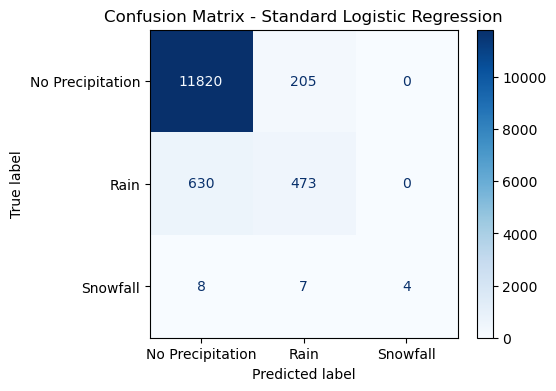

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix_standard = confusion_matrix(y_test, y_pred_standard)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(conf_matrix_standard, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Standard Logistic Regression')
plt.show()

It is evident that the severe imbalance in the target classes significantly impacted the model's performance, as seen in the confusion matrix above.   
The model performed very well in predicting instances of the majority class ('No Precipitation'), correctly identifying 11820 out of a total of 12025 instances. However, when it came to the minority classes, the model struggled. For 'Rain' events, it correctly predicted less than half of the instances (473 out of 1,103), and for the 'Snowfall' class, the model captured only 4 out of 19 events.   
This is a common challenge in classification tasks when dealing with imbalanced datasets, where the model tends to favor the majority class at the expense of the minority classes.

##### **The Precision-Recall Curve**

The next step in evaluating the model’s performance on the test set is to compute the Precision-Recall (PR) curve for each class: No Precipitation, Rain, and Snowfall. The PR curve visualizes the trade-off between precision and recall across various probability thresholds, making it a valuable tool for assessing models on imbalanced datasets.

This curve is particularly valuable for imbalanced datasets because it highlights how well the model performs on minority classes.   
As recall (the proportion of true positive predictions out of all actual positives) increases, the model tends to capture more true positive instances.
However, this often comes at the cost of precision (the proportion of true positive predictions out of all predicted positives), as more false positive predictions are introduced.

In the plot below, you can observe that as recall approaches 1, precision tends to decrease toward 0, illustrating the trade-off between these metrics. This behavior emphasizes the importance of balancing precision and recall achieving optimal performance for each class.

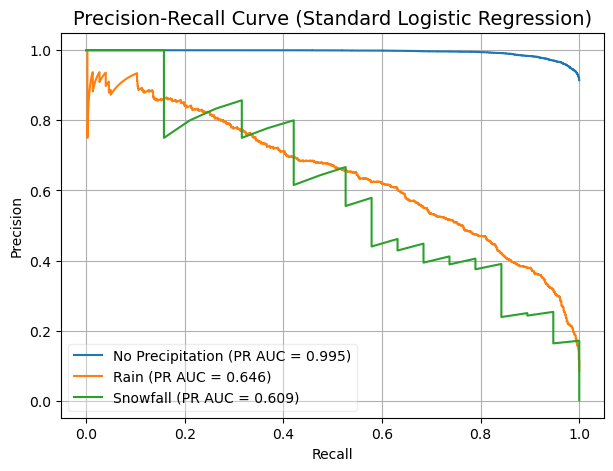

In [25]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Predicted probabilities
y_pred_probs_standard = standard_pipeline.predict_proba(X_test)

# Define class labels
class_labels = ['No Precipitation', 'Rain', 'Snowfall']

# Plot Precision-Recall curves
figure = plt.figure(figsize=(7, 5)) 
for i, label in enumerate(class_labels):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_standard[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    curve_plot = plt.plot(recall, precision, label=f'{label} (PR AUC = {pr_auc:.3f})')

# Add labels, title, and legend
xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title =plt.title('Precision-Recall Curve (Standard Logistic Regression)', fontsize=14)
legend = plt.legend(loc='lower left', framealpha=0.35)
grid = plt.grid(True)
plt.show()

##### **The Classification Report**

One more step in evaluating the model is to create a classification report, summarizing key metrics for each class:
precision, recall, F1-score, and PR AUC (Precision-Recall Area Under the Curve).
The classification report provides a detailed breakdown of these metrics for each class:
No Precipitation, Rain, and Snowfall.

Additionally, we calculate overall metrics:
- balanced_accuracy: more suitable for imbalanced datasets compared to simple accuracy.
- f1_weighted: accounts for the number of instances in each class, providing a balanced overall F1-score.
- pr_auc_weighted: aggregates the PR AUC score across all classes, offering a holistic view of model performance.
 
We transformed the report to a single-row DataFrame so as to make future comparisons with other models easier.

In [26]:
from sklearn.metrics import (
    classification_report, balanced_accuracy_score, f1_score, 
    average_precision_score, precision_recall_curve, auc
)

report_dict_standard = classification_report(y_test, y_pred_standard, digits=3, output_dict=True)
y_pred_probs_standard = standard_pipeline.predict_proba(X_test)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_standard[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_standard[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_standard[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_standard = pd.DataFrame({
    'precision_0': [report_dict_standard['0']['precision']],
    'recall_0': [report_dict_standard['0']['recall']],
    'f1_0': [report_dict_standard['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_standard['1']['precision']],
    'recall_rain': [report_dict_standard['1']['recall']],
    'f1_rain': [report_dict_standard['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_standard['2']['precision']],
    'recall_snow': [report_dict_standard['2']['recall']],
    'f1_snow': [report_dict_standard['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_standard)],
    'f1_weighted': [f1_score(y_test, y_pred_standard, average='weighted')],
    'pr_auc_weighted': [average_precision_score(y_test, y_pred_probs_standard, average='weighted')]
})

print('Standard Logistic Regression')
report_df_standard

Standard Logistic Regression


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
0,0.948788,0.982952,0.965568,0.994817,0.690511,0.42883,0.529083,0.646373,1.0,0.210526,0.347826,0.609086,0.54077,0.928055,0.965068


##### **Plotting the learning curve**

Before exploring the learning curve to gain insights into a model's performance, we must first understand what the curve represents.

A learning curve shows a model's performance with respect to a performance metric (in our case, balanced accuracy) as a function of the training set size (number of records). It visualizes how well the model learns patterns as the dataset increases in size, helping us understand if the model has learned from the data effectively or if there are issues like underfitting or overfitting. More concisely the learning curve's purpose is to illustrate how the model's performance evolves as the training set size increases.

Each point on the curve represents the average performance (from cross-validation) for a particular training size, providing an estimate of how well the model performs at that specific data volume. This helps us see if the model’s performance improves, deteriorates, or plateaus as we feed more data into the model.

In the plot, we have two curves: one (yellow) represents the average metric score on the training dataset, and the other (purple) represents the average metric score on the validation/test dataset.   
- If both curves are low relative to the y-axis and close to each other, the model may not be complex enough to capture data patterns and is likely underfitting.
- If the training curve is high but the validation curve is low, the model might be memorizing the training data without generalizing well, indicating overfitting.
- If both curves converge at a high level, the model is likely to perform well and generalizing effectively.

It is also important to observe whether the curves increase, plateau, or fluctuate as more data is fed to the model, as this indicates how additional data impacts performance.

Finally, you shouldn’t expect the performance metric on the test set (in our case balanced accuracy) from stratified cross-validation on the full dataset to exactly match the final point on the learning curve. Due to data randomness and differences in train-validation splits, the training and validation sets in the final point of the learning curve may differ from those used in cross-validation on the full dataset, leading to slight variations in metric results. The learning curve’s final point represents the average of cross-validated scores across multiple folds, while the test set score is a single evaluation on a fixed data split.

However, if the difference between the two metrics is significant, it’s worth investigating further. Potential issues could include model instability due to high complexity, overfitting to specific patterns in the data and more.

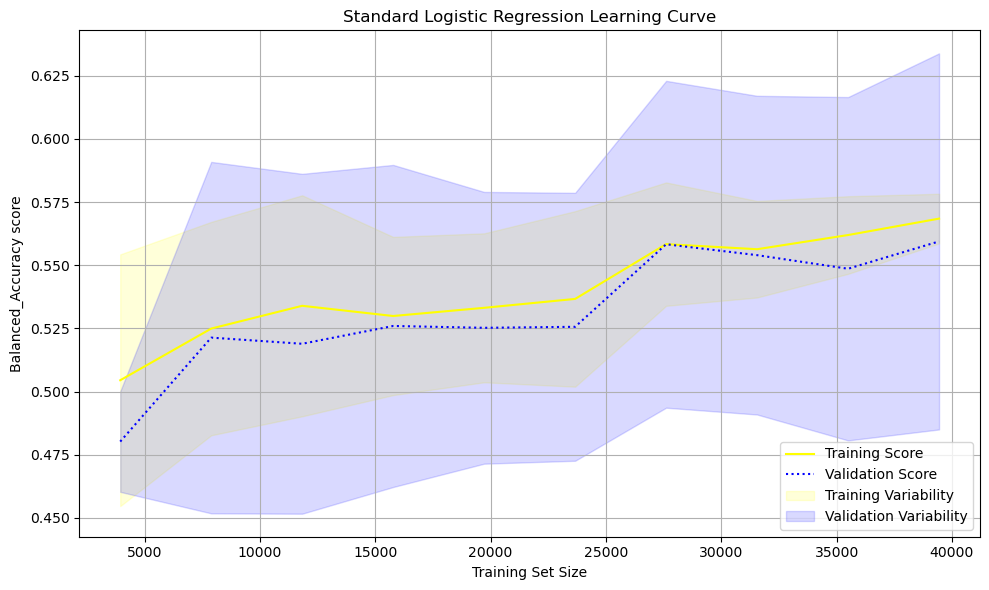

In [27]:
from sklearn.model_selection import StratifiedKFold
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    standard_pipeline, X, y, cv=stkf, scoring='balanced_accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', 
                            alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue',
                            alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Balanced_Accuracy score')
title = plt.title('Standard Logistic Regression Learning Curve')
legend = plt.legend(loc='lower right')
grid = plt.grid(True)
plt.tight_layout()
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

As the dataset size increases, the training and validation scores both improve. Even at 40,000 records, both curves exhibit a positive slope, indicating that the model continues to benefit from additional data. This suggests that further increasing the dataset size may lead to further improvements in performance.

The metric scores for the training and validation sets remain closely aligned throughout, with the validation score consistently lower. This alignment suggests mild underfitting, where the model is too simple to fully capture patterns in the data.

The variability in the training set performance decreases as the dataset size grows, reflecting a stabilization in the model's learning on the training data. However, the variability in the validation set performance remains significant and appears to continuously increase, suggesting instability in how well the model generalizes to unseen data. This instability is likely due to the class imbalance, which makes it challenging for the model to correctly predict minority class instances.

The combination of high bias (very low balanced accuracy scores ~0.56) and significant variance in the validation set suggests that the model is too simple to capture the complexity of the data and effectively distinguish between classes. 

Overall, the poor performance makes this model a suitable baseline for further development. Future efforts should focus on addressing class imbalance and improving both stability and predictive performance.

### Weighted Logistic Regression

The issue of severe class imbalance in the target variable was evident during the EDA process and became even more pronounced when we applied the Standard Logistic Regression model. The unbalanced classes in the target variable significantly impacted the model’s ability to predict minority class instances effectively.

To address this, we will fit a Logistic Regression model that attempts to balance the classes of the target variable. 

This iteration handles class imbalance by automatically adjusting the model to account for the uneven distribution of classes. (this is done by setting the argument `class_weight='balanced'`).   
In this *balanced mode*, the model automatically adjusts the weights of each class inversely proportional to their frequencies in the training data. This adjustment ensures that the minority classes receive more importance during training, without modifying the dataset itself.   

By implementing this weighting strategy, the model is expected to improve its ability to predict underrepresented classes, potentially leading to better recall and precision for these categories and finally better overall performance.

- separate the dataset into input space X (the predictor variables) and output space y (the target/response) variable

In [28]:
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

- data is split into a training set (70%) and a test set (30%) using stratified sampling to maintain the proportions of the target variable y in both sets. This ensures that the model is trained and evaluated with the same label distribution. The random state is set for reproducibility.

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

- Building the Model's Pipeline

This time, we will use the `SGDClassifier` class instead of the `LogisticRegression` class to classify the target variable.

The `SGDClassifier` class employs the Stochastic Gradient Descent **[SGD](https://scikit-learn.org/1.5/modules/sgd.html#sgd)** method as its optimization algorithm for the loss function, which updates the model's coefficients using small, randomly selected batches of data in each iteration. This stochastic approach significantly reduces computational cost per iteration and enables faster convergence, making it feasible to train the model even on (*below average*) machines with limited computational power.

To implement a weighted logistic regression model, we initialize the `SGDClassifier` with:
- `loss='log_loss'`

   to optimize the logistic loss function used in logistic regression.
- `class_weight='balanced'`

   to adjust class weights inversely proportional to their frequencies, ensuring that all classes contribute equally to the loss function despite imbalances in the dataset.


This setup provides a computationally efficient way to apply the weighted logistic regression approach.   
For more information on the `SGDClassifier` class, refer to **[the official documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.SGDClassifier.html).**

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

# Define the preprocessing step for Yeo-Johnson transformation
preprocessor = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), variables_to_transform),
], remainder='passthrough')  # Leave other features untouched

# Define the pipeline
weighted_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Step 1: Yeo-Johnson transformation for specific variables
    ('scaling', RobustScaler()),       # Step 2: Scale all features
    ('weighted_model', SGDClassifier(
        loss='log_loss',               # Logistic loss
        penalty='l2',                  # L2 regularization
        class_weight='balanced',       # Handle class imbalance
        max_iter=5000,                
        tol=1e-4,                      
        alpha=0.000025,                # Almost equivalent to C=1, in LogisticRegression() class
        learning_rate='optimal',      
        random_state=42
    ))
])


import time
start = time.time()

# Step 3: Fit the pipeline to the training data
weighted_pipeline.fit(X_train, y_train)

# Execution time and number of iterations for the solver to converge
execution_time = time.time() - start
print(f"Execution time: {execution_time:.2f} seconds")
weighted_model_fitted = weighted_pipeline['weighted_model']
print(f"Number of iterations for convergence: {weighted_model_fitted.n_iter_}")

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('yeo_johnson',
                                                  PowerTransformer(),
                                                  ['evapotranspiration_lag_1h',
                                                   'cloud_cover_low_lag_1h',
                                                   'cloud_cover_mid_lag_1h',
                                                   'direct_radiation_lag_1h',
                                                   'vapour_pressure_deficit_lag_1h'])])),
                ('scaling', RobustScaler()),
                ('weighted_model',
                 SGDClassifier(alpha=2.5e-05, class_weight='balanced',
                               loss='log_loss', max_iter=5000, random_state=42,
                               tol=0.0001))])

Execution time: 0.50 seconds
Number of iterations for convergence: 56


- extracting the predicted values of y by passing the test set features (X_test) into the trained model

In [31]:
y_pred_weighted = weighted_pipeline.predict(X_test)

#### Model Evaluation

- Setting up a 10-fold cross-validation with stratified sampling to ensure that each fold has the same proportion of classes as the original dataset. Setting the random state to ensure reproducibility. This stratified cross-validation will be used to evaluate the model's performance on the full data set before evaluating it on the *unseen* test set.

In [32]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

- run the cv assessment using the 10-folds created in the previous step. Printing the mean value of the metric across all folds along with its standard deviation.

In [33]:
logreg_weighted_cv = cross_val_score(weighted_pipeline, X, y, cv=stkf, scoring="balanced_accuracy", n_jobs=-1)
print(logreg_weighted_cv)
print(f'\nThe mean value of balanced_accuracy on the cv evaluation is {logreg_weighted_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy on the cv evaluation is {logreg_weighted_cv.std().round(3)}')

[0.90089567 0.87368379 0.89031177 0.90358414 0.82208409 0.76822804
 0.89570135 0.8638701  0.84515105 0.90748019]

The mean value of balanced_accuracy on the cv evaluation is 0.867

The standard deviation of balanced_accuracy on the cv evaluation is 0.042


The cv evaluation on the full dataset this time resulted in acceptable levels for the balanced accuracy metric around 0.87, and more importantly this was achieved consistently across all 10 folds with a minor standard deviation of 0.04. It seems that the balanced (weighted) approach did a much better job this time in distinguishing between the classes.   
This of course will be further justified when we assess the model's performance solely in the test `unseen` data set.

##### **The Confusion Matrix**

- Generating the confusion matrix to visualize the performance of the model on the test set this time. The confusion matrix shows how well the model predicted each class by displaying the true positive, false positive, true negative, and false negative counts for each class ('No Precipitation', 'Rain', 'Snowfall').

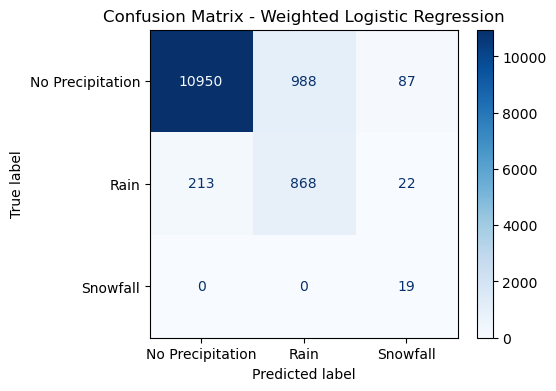

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_weighted, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Weighted Logistic Regression')
plt.show()

Using the `class_weight='balanced'` argument in the algorithm, we achieved significantly better results for the minority classes. The model correctly captured 868 'rain' events out of a total of 1103 instances, and even better results for the 'snowfall' class, where it captured all 19 instances. Additionally, false negatives (i.e., instances where the true label was misclassified as 'no precipitation') decreased substantially. For example, the model incorrectly predicted 'no precipitation' instead of 'rain' only 213 times, compared to 630 times in the unweighted standard approach.

However, this improvement in recall for the minority classes came at the cost of precision for the majority class ('no precipitation'). The true positives for 'no precipitation' dropped from 11820 to 10950, and false positives (i.e., predicting 'rain' or 'snowfall' instead of 'no precipitation') increased significantly—from 205 in the standard model to 1075 (988+87) in the weighted approach.

This demonstrates the precision-recall trade off: by focusing on improving recall for minority classes, the model sacrifices precision, particularly for the majority class. These results highlight the challenges of balancing class performance in imbalanced datasets.

##### **The Precision-Recall Curve**

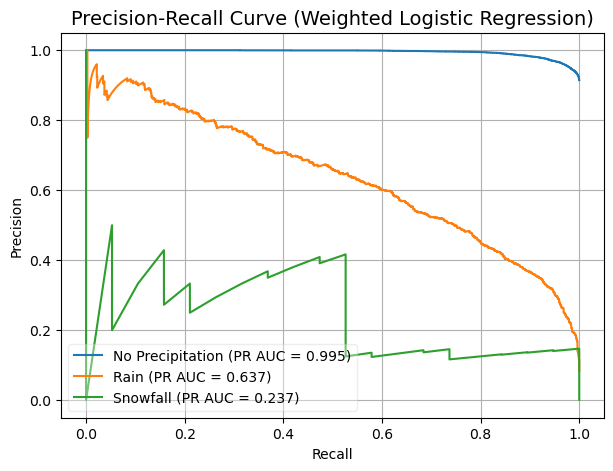

In [35]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Predicted probabilities
y_pred_probs_weighted = weighted_pipeline.predict_proba(X_test)

# Define class labels
class_labels = ['No Precipitation', 'Rain', 'Snowfall']

# Plot Precision-Recall curves
figure = plt.figure(figsize=(7, 5))  # Slightly larger figure for clarity
for i, label in enumerate(class_labels):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_weighted[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    curve_plot = plt.plot(recall, precision, label=f'{label} (PR AUC = {pr_auc:.3f})')

# Add labels, title, and legend
xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title =plt.title('Precision-Recall Curve (Weighted Logistic Regression)', fontsize=14)
legend = plt.legend(loc='lower left', framealpha=0.35)
grid = plt.grid(True)
plt.show()

##### **The Classification Report**

In [45]:
from sklearn.metrics import (
    classification_report, balanced_accuracy_score, f1_score, 
    average_precision_score, precision_recall_curve, auc
)
report_dict_weighted = classification_report(y_test, y_pred_weighted, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_weighted[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_weighted[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_weighted[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_weighted = pd.DataFrame({
    'precision_0': [report_dict_weighted['0']['precision']],
    'recall_0': [report_dict_weighted['0']['recall']],
    'f1_0': [report_dict_weighted['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_weighted['1']['precision']],
    'recall_rain': [report_dict_weighted['1']['recall']],
    'f1_rain': [report_dict_weighted['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_weighted['2']['precision']],
    'recall_snow': [report_dict_weighted['2']['recall']],
    'f1_snow': [report_dict_weighted['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_weighted)],
    'f1_weighted': [f1_score(y_test, y_pred_weighted, average='weighted')],
    'pr_auc_weighted': [average_precision_score(y_test, y_pred_probs_weighted, average='weighted')]
})

print('Weighted Logistic Regression')
report_df_weighted

Weighted Logistic Regression


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
0,0.980919,0.910603,0.944454,0.99467,0.467672,0.786945,0.586685,0.637385,0.148438,1.0,0.258503,0.237102,0.899183,0.913447,0.96367


##### **Plotting the learning curve**

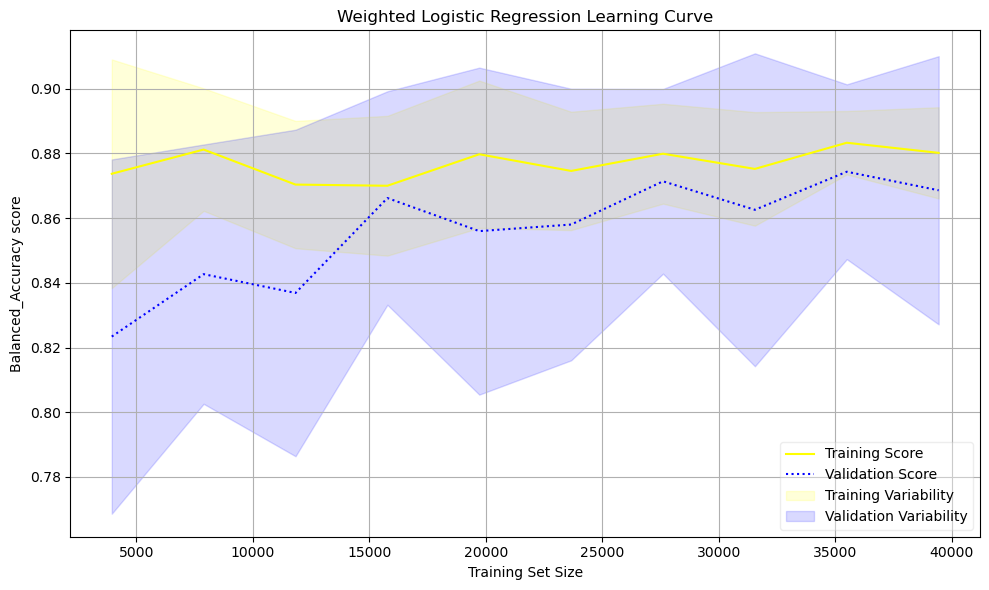

In [37]:
from sklearn.model_selection import learning_curve
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    weighted_pipeline, X, y, cv=stkf, scoring='balanced_accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', 
                            alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', 
                            alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Balanced_Accuracy score')
titel = plt.title('Weighted Logistic Regression Learning Curve')
legend = plt.legend(loc='lower right', framealpha=0.35)
grid = plt.grid(True)
plt.tight_layout()
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The learning curve for the weighted logistic regression model demonstrates significant improvement in handling class imbalance compared to the standard logistic regression model. While the training score stabilizes around 0.88, the validation score steadily increases as the dataset size increase, reaching approximately 0.87 at the maximum dataset size of 40,000 records. Both curves appear to plateau near this point, suggesting that adding more data may not lead to further improvements in the model's performance. The slightly higher training score relative to the validation score indicates a mild but acceptable degree of overfitting.  

While variability in the validation scores remains significant due to the dataset's imbalanced nature, it decreases as the dataset size grows, reflecting a more stable performance, but still there is room for improvement.

The weighted logistic regression model successfully balances precision and recall across classes, resulting in higher training and validation scores and more reliable predictions compared to the standard model. It demonstrates acceptable performance in addressing class imbalance, achieving relatively low bias and maintaining reasonable levels of variance.   

However, while the results are promising, there is still room for improvement, especially in further reducing the variance of the model and enhancing the generalization capability.

### Logistic Regression with Oversampling using SMOTE

Moving one step further we will try to address the challenges posed by the heavily imbalanced dataset, this time by employing an oversampling technique to balance the classes in the training data.   

In this iteration, we will use the SMOTE (Synthetic Minority Over-sampling Technique) method to generate artificial samples for the minority classes. Oversampling the minority classes helps to improve the model’s ability to make predictions, since by training the model on a more balanced dataset, we aim to improve the recall for minority classes while maintaining the overall model accuracy.

SMOTE creates synthetic records by interpolating between existing samples of the minority class and their nearest neighbors. This approach increases the representation of minority classes in the training set, ensuring that each class is equally represented.   
The original test set is left untouched and retains its class imbalance so as to ensure an unbiased evaluation of the model’s performance.   
Further details on SMOTE can be found in the **[official documentation](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)**.

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('yeo_johnson',
                                                  PowerTransformer(),
                                                  ['evapotranspiration_lag_1h',
                                                   'cloud_cover_low_lag_1h',
                                                   'cloud_cover_mid_lag_1h',
                                                   'direct_radiation_lag_1h',
                                                   'vapour_pressure_deficit_lag_1h'])])),
                ('scaling', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('oversampling_model',
                 SGDClassifier(alpha=2.5e-05, loss='log_loss', max_iter=5000,
                               random_state=42, tol=0.0001))])

Execution time: 1.77 seconds
Number of iterations for convergence: 56
[0.9125282  0.91663232 0.86017768 0.92958106 0.86792719 0.91696498
 0.91340688 0.85673579 0.86665625 0.92821171]

The mean value of balanced_accuracy on the cv evaluation is 0.897

The standard deviation of balanced_accuracy on the cv evaluation is 0.028




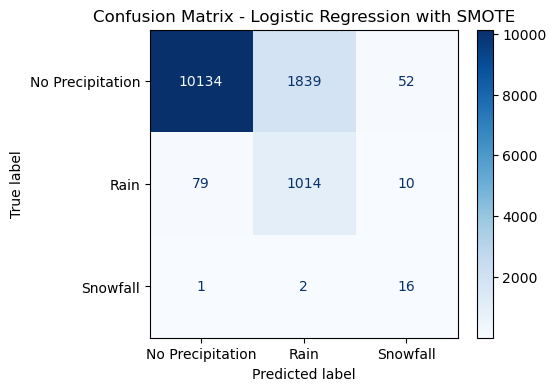

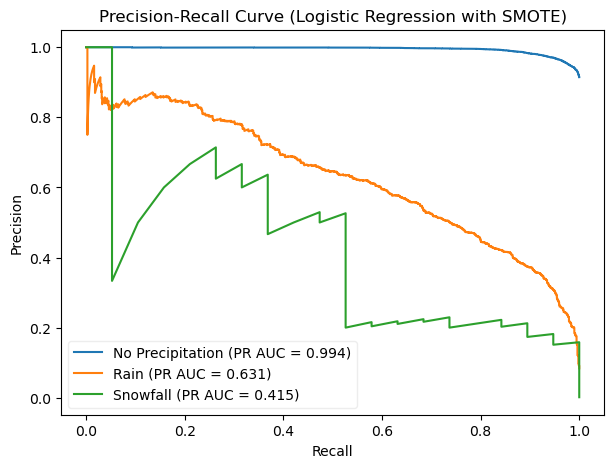

Logistic Regression with SMOTE


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
0,0.992168,0.842744,0.911372,0.994388,0.355166,0.919311,0.51238,0.63076,0.205128,0.842105,0.329897,0.415117,0.868054,0.877057,0.9631


In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import time

# Define features (X) and target (y)
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Define the preprocessing step for Yeo-Johnson transformation
preprocessor = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), variables_to_transform),
], remainder='passthrough')  # Leave other features untouched

# Define the pipeline with SMOTE
oversampling_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Step 1: Yeo-Johnson transformation for specific variables
    ('scaling', RobustScaler()),       # Step 2: Scale all features
    ('smote', SMOTE(random_state=42)), # Step 3: Apply SMOTE to oversample the minority classes
    ('oversampling_model', SGDClassifier(
        loss='log_loss',               # Logistic loss
        penalty='l2',                  # L2 regularization
        alpha=0.000025,                # Equivalent to C=1 for 40,000 records
        max_iter=5000,                
        tol=1e-4,                      
        learning_rate='optimal',       
        random_state=42
    ))
])

# Fit the pipeline to the training data
start = time.time()
oversampling_pipeline.fit(X_train, y_train)
execution_time = time.time() - start

# Access fitted model and print details
oversampled_model_fitted = oversampling_pipeline['oversampling_model']
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Number of iterations for convergence: {oversampled_model_fitted.n_iter_}")


# Predict on the true test set
y_pred_smote = oversampling_pipeline.predict(X_test)

# Evaluate the model using cross-validation on the full data set
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
smote_cv = cross_val_score(oversampling_pipeline, X, y, cv=stkf, scoring="balanced_accuracy", n_jobs=-1)

print(smote_cv)
print(f'\nThe mean value of balanced_accuracy on the cv evaluation is {smote_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy on the cv evaluation is {smote_cv.std().round(3)}')
print('\n')

# Confusion Matrix
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_smote, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Logistic Regression with SMOTE')
plt.show()

# Define the class labels
class_labels = ['No Precipitation', 'Rain', 'Snowfall']

# Producing the probabilities of each class for every data record in the test set
y_pred_probs_smote = oversampling_pipeline.predict_proba(X_test)

# Plot Precision-Recall curves
figure = plt.figure(figsize=(7, 5))  
for i, label in enumerate(class_labels):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_smote[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plot = plt.plot(recall, precision, label=f'{label} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (Logistic Regression with SMOTE)')
legend = plt.legend(loc='lower left', framealpha=0.35)
plt.show()

# Classification report
report_dict_smote = classification_report(y_test, y_pred_smote, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_smote[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_smote[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_smote[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_smote = pd.DataFrame({
    'precision_0': [report_dict_smote['0']['precision']],
    'recall_0': [report_dict_smote['0']['recall']],
    'f1_0': [report_dict_smote['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_smote['1']['precision']],
    'recall_rain': [report_dict_smote['1']['recall']],
    'f1_rain': [report_dict_smote['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_smote['2']['precision']],
    'recall_snow': [report_dict_smote['2']['recall']],
    'f1_snow': [report_dict_smote['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_smote)],
    'f1_weighted': [f1_score(y_test, y_pred_smote, average='weighted')],
    'pr_auc_weighted': [average_precision_score(y_test, y_pred_probs_smote, average='weighted')]

})

# Display the DataFrame
print('Logistic Regression with SMOTE')
report_df_smote

The Logistic Regression with SMOTE iteration demonstrated significant improvements in handling class imbalance. The model achieved a mean balanced accuracy almost at 0.9 across all folds of the full data set, with a low standard deviation of 0.03, indicating consistent and stable performance. 
On the test set, the model showed improved recall for minority classes ('Rain' and 'Snowfall'), capturing 1,014 'Rain' events (868 in the weighted iteration) and 16 'Snowfall' events, though the PR AUC for 'Snowfall' remained low at 0.415, reflecting challenges in precision. 
The majority class ('No Precipitation') maintained high recall, but this time the TP instances fell from 10950 to 10134. 
Although the precision-recall trade-off is evident, the SMOTE-enhanced model achieved balanced and robust results, especially in recall for the minority classes.

##### **Plotting the learning curve**

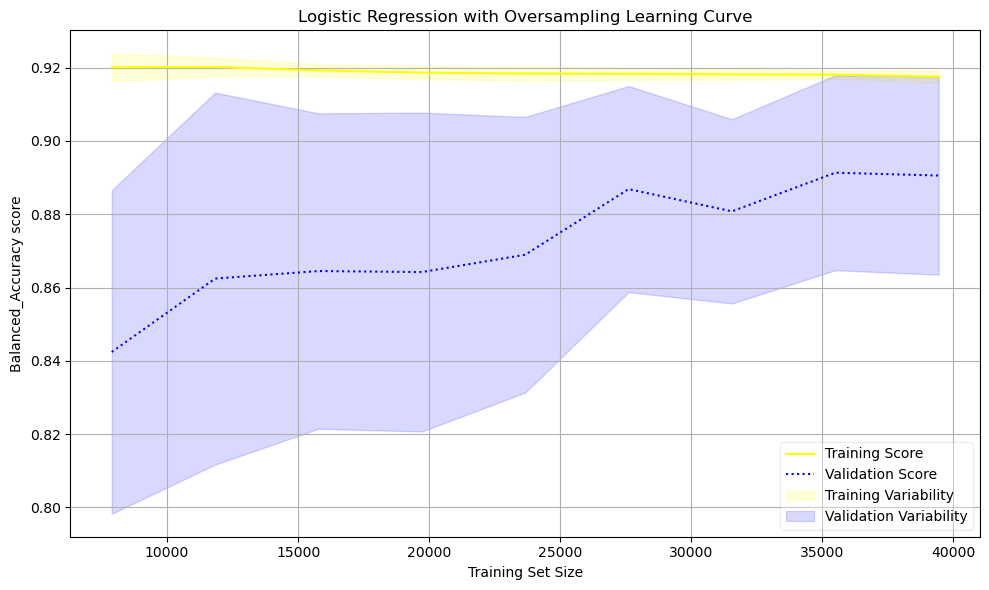

In [39]:
from sklearn.model_selection import learning_curve
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    oversampling_pipeline, X, y, cv=stkf, scoring='balanced_accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', 
                            alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', 
                            alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Balanced_Accuracy score')
titel = plt.title('Logistic Regression with Oversampling Learning Curve')
legend = plt.legend(loc='lower right', framealpha=0.35)
grid = plt.grid(True)
plt.tight_layout()
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The learning curve for the SMOTE-enhanced logistic regression model shows that the training set performance plateaus around a balanced accuracy of 0.92, reflecting low bias. This indicates that the model effectively learns patterns in the training data. The training variability is minimal and approaches zero as the dataset size increases to 40,000 records.

The validation set performance steadily improves as more training data is provided, stabilizing around 0.89. However, the persistent variance in validation scores suggests challenges with generalization. This variability likely arises from the synthetic data generated by SMOTE, which possibly make the model struggle to generalize effectively to unseen data.

While the training and validation scores are reasonably close, the gap between the two curves points to a mild overfitting issue, which seems to have increased compared to the previous 'weighted' iteration. The overfitting may stem from the inherent complexity of the dataset or limitations in the model's capacity to capture subtle patterns, particularly in the context of class imbalance.

The primary concern however remains the variance in the validation set, which indicates instability and suggests that the model's generalization is sensitive to `unseen data`.

The SMOTE-enhanced model, while exhibiting low bias, still has issues with the variance, highlighting the need for additional tuning or alternative techniques to enhance stability and generalization.

### One-vs-Rest (OvR) Multinomial Logistic Regression

Following the previous section where we applied an upsampling technique (SMOTE) to handle class imbalance and enhance the logistic regression model's performance, this time in the search for a possible improvement we will explore a more complex model.
This variant is the One-vs-the-Rest (OvR) strategy.   
Also known as one-vs-all, this strategy involves fitting one classifier per class, where each class is fitted against all the other classes, effectively transforming the multiclass problem into multiple binary classification problems, which in the end will be combined again to construct the final multiclass model.   

By wrapping the `SGDClassifier()` class inside the OvR strategy, we can build separate binary classifiers for each class and combine their predictions to perform multiclass classification. *(each binary classifier outputs a score (a probability) for its respective class, and the final prediction is made by selecting the class with the highest score(probability)).*   

While initially this seems unorthodox and naturally more computationally intensive, the goal of using this strategy is to reveal/identify patterns of the data at the binary level which might not be evident at the multi-class level and sometimes can enhance the model's ability to distinguish between classes.  
For more information, you can refer to the  **[official documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)**

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('yeo_johnson',
                                                  PowerTransformer(),
                                                  ['evapotranspiration_lag_1h',
                                                   'cloud_cover_low_lag_1h',
                                                   'cloud_cover_mid_lag_1h',
                                                   'direct_radiation_lag_1h',
                                                   'vapour_pressure_deficit_lag_1h'])])),
                ('scaling', RobustScaler()),
                ('ovr_model',
                 OneVsRestClassifier(estimator=SGDClassifier(alpha=2.5e-05,
                                                             class_weight='balanced',
                                                             loss='log_loss',
                                                             max_iter=5000,
                                                             random_state=42,
                                                             tol=0.0001)))])

Execution time: 0.61 seconds
Class 0: Number of iterations = 55
Class 1: Number of iterations = 55
Class 2: Number of iterations = 34
[0.90160078 0.86778384 0.85258055 0.91930451 0.85635251 0.90354436
 0.90463819 0.89866103 0.90954118 0.90342574]

The mean value of balanced_accuracy is 0.892

The standard deviation of balanced_accuracy is 0.022



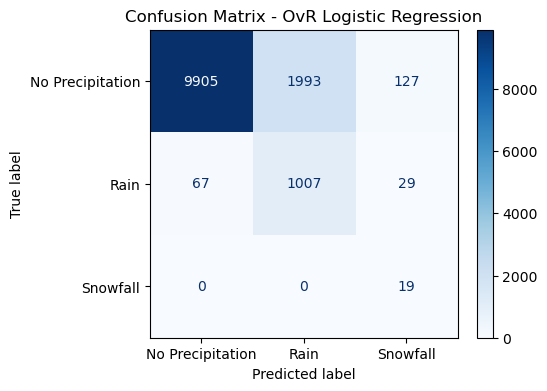

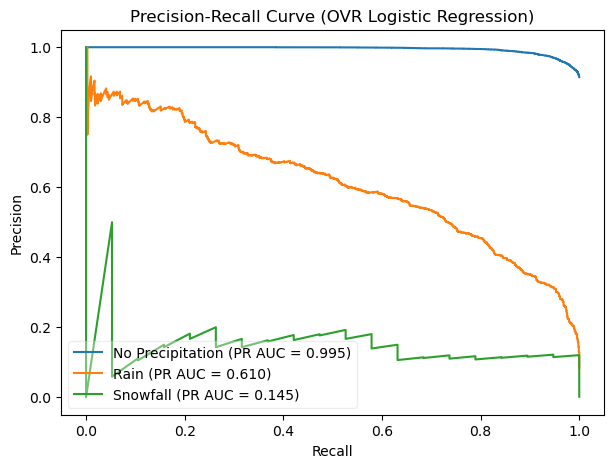

Logistic Regression with OVR


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
0,0.993281,0.823701,0.900577,0.994733,0.335667,0.912965,0.49086,0.610387,0.108571,1.0,0.195876,0.14532,0.912222,0.865185,0.961325


In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

# Define features (X) and target (y)
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Define the preprocessing step for Yeo-Johnson transformation
preprocessor = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), variables_to_transform),
], remainder='passthrough')  # Leave other features untouched

# Define the pipeline
ovr_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Step 1: Yeo-Johnson transformation for specific variables
    ('scaling', RobustScaler()),       # Step 2: Scale all features
    ('ovr_model', OneVsRestClassifier(SGDClassifier(
        loss='log_loss',               # Logistic loss
        penalty='l2',                  # L2 regularization
        class_weight='balanced',
        alpha=0.000025,                # Equivalent to C=1 for 40,000 records
        max_iter=5000,                
        tol=1e-4,                      
        learning_rate='optimal',      
        random_state=42
    )))
])

# Fit the pipeline
import time
start = time.time()

ovr_pipeline.fit(X_train, y_train)

execution_time = time.time() - start
print(f"Execution time: {execution_time:.2f} seconds")

# Check the number of iterations for each classifier in the OneVsRest setup
for i, estimator in enumerate(ovr_pipeline['ovr_model'].estimators_):
    print(f"Class {i}: Number of iterations = {estimator.n_iter_}")


# Predict on the test set
y_pred_ovr = ovr_pipeline.predict(X_test)

from sklearn.model_selection import StratifiedKFold
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

logreg_ovr_cv = cross_val_score(ovr_pipeline, X, y, cv=stkf, scoring="balanced_accuracy", n_jobs=-1)
print(logreg_ovr_cv)
print(f'\nThe mean value of balanced_accuracy is {logreg_ovr_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy is {logreg_ovr_cv.std().round(3)}\n')

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix_ovr = confusion_matrix(y_test, y_pred_ovr)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ovr, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - OvR Logistic Regression')
plt.show()

# Class labels
class_labels = ['No Precipitation', 'Rain', 'Snowfall']

# Producing the probabilities of each class for every data record in the test set
y_pred_probs_ovr = ovr_pipeline.predict_proba(X_test)

# Initialize plot
figure = plt.figure(figsize=(7, 5))  

# Loop through each class
for i, label in enumerate(class_labels):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_ovr[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve for the class
    pr_curve = plt.plot(recall, precision, label=f'{label} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (OVR Logistic Regression)')
legend = plt.legend(loc='lower left', framealpha=0.35)
plt.show()

# Classification report
report_dict_ovr = classification_report(y_test, y_pred_ovr, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_ovr[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_ovr[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_ovr[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_ovr = pd.DataFrame({
    'precision_0': [report_dict_ovr['0']['precision']],
    'recall_0': [report_dict_ovr['0']['recall']],
    'f1_0': [report_dict_ovr['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_ovr['1']['precision']],
    'recall_rain': [report_dict_ovr['1']['recall']],
    'f1_rain': [report_dict_ovr['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_ovr['2']['precision']],
    'recall_snow': [report_dict_ovr['2']['recall']],
    'f1_snow': [report_dict_ovr['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_ovr)],
    'f1_weighted': [f1_score(y_test, y_pred_ovr, average='weighted')],
    'pr_auc_weighted': [average_precision_score(y_test, y_pred_probs_ovr, average='weighted')]

})

# Display the DataFrame
print('Logistic Regression with OVR')
report_df_ovr

##### **Plotting the learning curve**

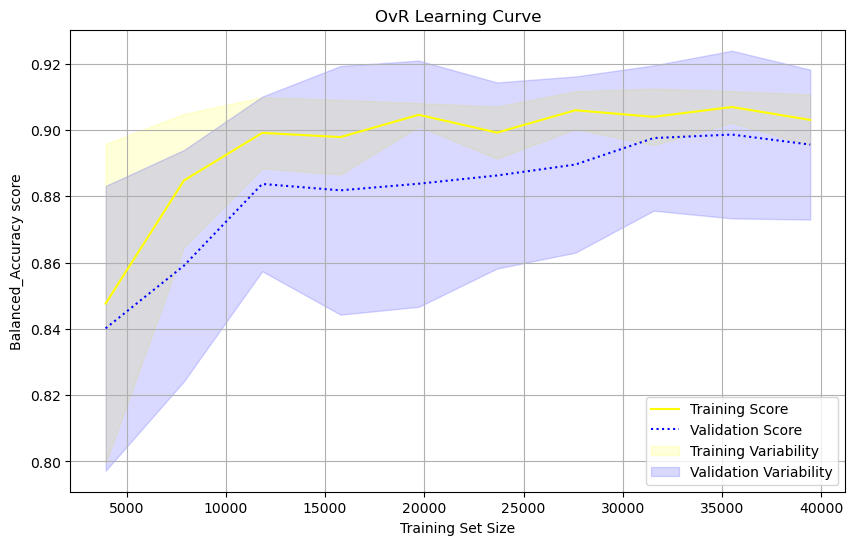

In [41]:
from sklearn.model_selection import StratifiedKFold
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    ovr_pipeline, X, y, cv=stkf, scoring='balanced_accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', 
                            alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', 
                            alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Balanced_Accuracy score')
title = plt.title('OvR Learning Curve')
legend = plt.legend(loc='lower right')
grid = plt.grid(True)
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The learning curve for the One-vs-Rest logistic regression model indicates strong performance on the training set, with scores plateauing ~0.90+, reflecting low bias. The validation score follows a similar trend, plateauing slightly lower ~0.90- as the dataset size increases. This alignment between the training and validation scores suggests that the model generalizes reasonably well without signs of overfitting to mention.

The variability in the validation scores, particularly at smaller training sizes, reflects some instability when fewer data points are available for training. However, as the training size grows to 40,000 records, this variability reduces, highlighting the model's ability to provide consistently stable predictions.

The One-vs-Rest approach effectively captures class-specific nuances, offering improved generalization over the previous iterations while maintaining balanced accuracy across all classes. The plateauing of both training and validation scores indicates that further increases in data may not significantly enhance performance.   
Nonetheless, we shall try to optimize this iteration and see if we can further reduce the variance in the validation set while keeping the bias at the same low level.

### Hyperparameter Optimized Logistic Regression

Up to this point we have seen than each iteration provided an improvement upon the poor baseline model. The OVR iteration seems to have provided the best solution, not for predicting the most TP instances for all 3 classes, or the higher balanced accuracy (~0.90 for both training and validation scores), but because it exhibited the lowest variance out of all iterations and the gap between training and validation scores is minimal, indicating no signs of overfitting.   

This is the reason why the last iteration will be built upon the OVR approach, but this time we will attempt to fine tune it and see if we can further improve the model's performance.

We have also realized since now that the SGDClassifier() class has several arguments/parameters, each with multiple options from which you can choose.

In the **[official documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.SGDClassifier.html)**, for the SGDClassifier you can find the full set of parameters like `alpha=`, `learning_rate=`, `eta0=`. You may have also noticed that changing even a single parameter value can significantly alter the model's performance. Is there a way to explore all available options for these parameters and their combinations? For example having 3 parameters that each can take 5 values, this will lead to a total number of 5^3 = 125 possible combinations. Of course you can find and apply this 125 possible combinations manually but this can be time consuming and in cases with a lot of parameters with a big range of possible values, impractical.

There is a more effective way to search for all possible combinations using **[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)**, where you manually define the parameter space, and the method will take over, creating and exploring all possible combinations for you, evaluating the model based on a specified evaluation metric, and return the best model along with its set of optimal parameters.   
It is important to note that GridSearchCV accepts only discrete values for each parameter, defined by the user. For example, if each parameter takes 20 possible values, this will result in a very large number of combinations, making the method computationally expensive and often impractical for larger search spaces.

There is an alternative method called **[RandomizedSearchCV](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)**, which speeds up the process by randomly selecting values from the parameter space you have defined. You specify how many combinations should be evaluated by setting the `n_iter` argument. The method evaluates these combinations and returns the best model along with its corresponding parameters. This approach significantly reduces the computational time but does not guarantee that it will find the absolute best model, given the dataset and parameter space at hand.

In this section, we will use another method called **[BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)**, which performs Bayesian optimization. This method intelligently searches the hyperparameter space using a probabilistic model to guide the search, making it more efficient than traditional methods like `GridSearchCV` and `RandomizedSearchCV`.

The process begins by defining the hyperparameter search space. Initially, BayesSearchCV performs a small number of random evaluations by selecting different combinations of hyperparameters. These initial evaluations explore diverse regions of the parameter space to gather data. Based on this data, the algorithm builds a probabilistic model, which helps predict which areas of the hyperparameter space are most likely to contain optimal combinations.

This approach significantly reduces the number of hyperparameter combinations that need to be evaluated, making it much more efficient. The best model and its optimal hyperparameter settings are returned after evaluating all combinations.
Even though this method is much more efficient, there’s a degree of randomness in the cross-validation process and in the initial random samples selected during the BayesSearchCV process. This might cause optimization to focus on suboptimal areas of the hyperparameter space and it does not guarantee that you will indeed end up with the best possible model settings. An increase on the n_iter argument (the number of parameter combinations) can help in this direction but it will also increase the computational cost. Experience also will be valuable since you can restrict the hyperparameter space if you already know where the best possible combination might lie and this can be set by defining the prior distribution in the prior argument of each parameter you aim to search and optimize.

<u>Key points on BayesSearchCV</u>
- The n_iter argument is specified by the user when calling BayesSearchCV(). After setting this parameter, the user no longer controls how the algorithm selects combinations within the search space. For example, if n_iter=30, the algorithm will evaluate 30 different hyperparameter combinations in total. Initially, a small number of combinations are randomly selected and evaluated. Based on these initial evaluations, the algorithm builds a probabilistic model, which it then uses to guide the remaining iterations, focusing on combinations that are predicted to yield better performance. The best model from all 30 evaluations is returned as the final model.
- Increasing the n_iter argument, increases your chances of finding the best possible model, but at the same time you are also increasing your computational costs (time and resources)
- Initially, BayesSearchCV performs a few random evaluations of hyperparameter combinations (the rest combinations will be used after the probabilistic model is build). These initial samples are influenced by the **`prior`** distribution that we define for each parameter (e.g., `log-uniform` for `alpha`). The prior distribution represents our **initial belief** about where the best hyperparameters might lie.
- In this phase, random hyperparameter values are sampled from the defined search space, but the **`prior`** (e.g., `log-uniform`) influences the frequency with which different values are selected. For example, if you're using 'log-uniform' for 'alpha', smaller values will be sampled more often than larger values, because this is your initial/prior belief of where the best parameters might lie.
- If your initial guess/belief about the prior distribution for sampling values is incorrect, don't worry. This will be reflected in the probabilistic model built by the algorithm, based on the poor performance of the models built using that prior. These poor results will prompt the algorithm to adapt, and guide the search towards more promising ranges. Therefore, it is the range of the parameter values that you should be careful not to restrict. An incorrect initial prior probability will not prevent the algorithm from finding good solutions, as it will adjust during the search.
- After evaluating the initial random samples, BayesSearchCV builds a **probabilistic model**. This model then uses the updated probabilities distribution (*posterior distribution*), which is the updated belief about where the best hyperparameters might lie after incorporating the results of the initial evaluations.
- From this point, the **posterior distribution** is used to guide the search. The algorithm no longer selects hyperparameters randomly; instead, it uses the posterior distribution to focus the search on areas of the hyperparameter space that are predicted to perform better.

**Last important note**   
While BayesSearchCV is more effective than traditional methods at exploring and exploiting the hyperparameter space, it still cannot guarantee the optimal set of parameters—and thus the best possible model-, <u>**due to its probabilistic nature**.</u>   
Additionally, while BayesSearchCV is more effective, choosing a large number of possible parameter combinations (via the n_iter argument, e.g., 500), setting a high maximum number of iterations for the selected solver to minimize the loss function and converge (via the max_iter argument, e.g., 15000) and the tolerance to smaller values like tol=0.000001, can lead to significantly increased computational costs, potentially taking several hours to return a result.   

For more information on the BayesSearchCV, please refer to the following links:   
https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html   
and   
https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.skopt.BayesSearchCV.html

Before running the script below, ensure that you have run the following:     
`pip install scikit-optimize`

In [336]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.model_selection import StratifiedKFold

# Define the preprocessing step for Yeo-Johnson transformation
preprocessor = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), variables_to_transform),
], remainder='passthrough')  # Leave other features untouched

# Define the pipeline
ovr_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Step 1: Yeo-Johnson transformation for specific variables
    ('scaling', RobustScaler()),       # Step 2: Scale all features
    ('ovr_model', OneVsRestClassifier(SGDClassifier(
        loss='log_loss',               # Logistic loss
        class_weight='balanced',
        max_iter=5000,            
        warm_start=True,
        tol=1e-4,    
        random_state=42
    )))
])

# Define the parameter search space
param_space = {
    'ovr_model__estimator__alpha': Real(1e-6, 1e-2, prior='log-uniform'),
    'ovr_model__estimator__learning_rate': Categorical(['constant', 'optimal', 'invscaling', 'adaptive']),
    'ovr_model__estimator__eta0': Real(1e-4, 1e-1, prior='log-uniform'),
    'ovr_model__estimator__penalty': Categorical(['l2', 'l1', 'elasticnet'])
}

# Stratified k-fold cross-validation
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# BayesSearchCV for hyperparameter tuning
bayes_search = BayesSearchCV(
    estimator=ovr_pipeline,
    search_spaces=param_space,
    n_iter=20,  # Number of parameter combinations to evaluate
    scoring='balanced_accuracy',
    cv=stkf,
    random_state=42,
    n_jobs=-1
)

# Fit BayesSearchCV to the training data
import time
start = time.time()
bayes_search.fit(X_train, y_train)
execution_time = time.time() - start

# Output results
print("Best parameters found")
bayes_search.best_params_
print("Best cross-validation score")
bayes_search.best_score_
print(f"Execution time: {execution_time:.2f} seconds")

# Extract and save detailed results
results_df = pd.DataFrame(bayes_search.cv_results_)

BayesSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('preprocessing',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('yeo_johnson',
                                                                          PowerTransformer(),
                                                                          ['evapotranspiration_lag_1h',
                                                                           'cloud_cover_low_lag_1h',
                                                                           'cloud_cover_mid_lag_1h',
                                                                           'direct_radiation_lag_1h',
                                                                           'vapour_pressure_deficit_lag_1h'])]))...
              search_spaces={'ovr_model__estimator__alpha': Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
                             'ovr_model__estimator__eta0': Real(low=0.0001, high=0.1, prior='log-uniform', transform='normalize'),
                             'ovr_model__estimator__learning_rate': Categorical(categories=('constant', 'optimal', 'invscaling', 'adaptive'), prior=None),
                             'ovr_model__estimator__penalty': Categorical(categories=('l2', 'l1', 'elasticnet'), prior=None)})

Best parameters found


OrderedDict([('ovr_model__estimator__alpha', 4.3693399475103194e-05),
             ('ovr_model__estimator__eta0', 0.015246748254295629),
             ('ovr_model__estimator__learning_rate', 'adaptive'),
             ('ovr_model__estimator__penalty', 'l2')])

Best cross-validation score


0.9064328221323399

Execution time: 57.92 seconds


In [337]:
bayes_best_model = bayes_search.best_estimator_
y_pred_bayes_grid = bayes_best_model.predict(X_test)

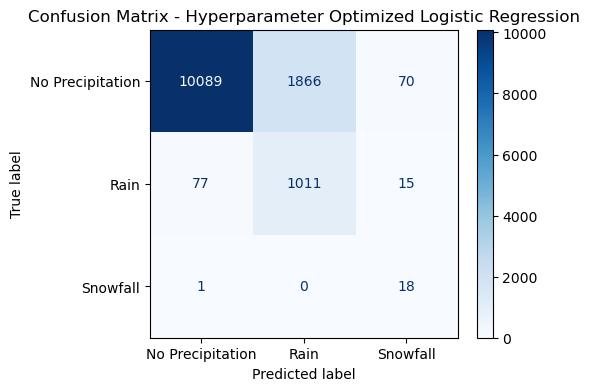

In [338]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(figsize=(5, 4))
conf_matrix_bayes_grid = confusion_matrix(y_test, y_pred_bayes_grid)
disp = ConfusionMatrixDisplay(conf_matrix_bayes_grid, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Hyperparameter Optimized Logistic Regression')
plt.show()

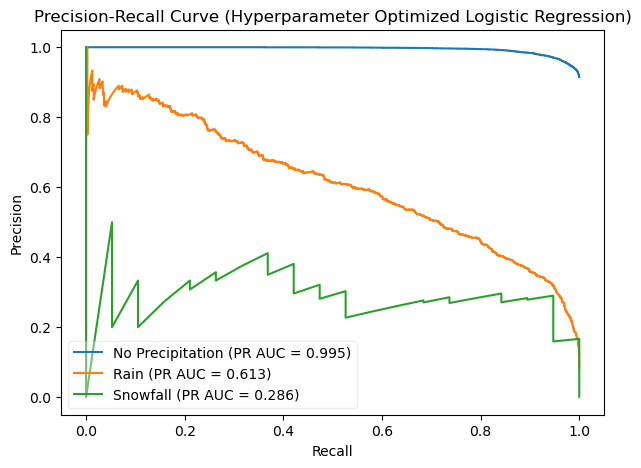

In [339]:
# Generate precision-recall curve for each class
y_pred_probs_bayes_grid = bayes_best_model.predict_proba(X_test)

# Class labels
class_labels = ['No Precipitation', 'Rain', 'Snowfall']

# Initialize plot
figure = plt.figure(figsize=(7, 5))  
for i, label in enumerate(class_labels):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_bayes_grid[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plot = plt.plot(recall, precision, label=f'{label} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (Hyperparameter Optimized Logistic Regression)')
legend = plt.legend(loc='lower left', framealpha=0.35)
plt.show()

In [340]:
# Classification report
report_dict_grid = classification_report(y_test, y_pred_bayes_grid, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_bayes_grid[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_bayes_grid[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_bayes_grid[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)
# Create a single row dataframe with the required metrics
report_df_bayes_grid = pd.DataFrame({
    'precision_0': [report_dict_grid['0']['precision']],
    'recall_0': [report_dict_grid['0']['recall']],
    'f1_0': [report_dict_grid['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_grid['1']['precision']],
    'recall_rain': [report_dict_grid['1']['recall']],
    'f1_rain': [report_dict_grid['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_grid['2']['precision']],
    'recall_snow': [report_dict_grid['2']['recall']],
    'f1_snow': [report_dict_grid['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_bayes_grid)],
    'f1_weighted': [f1_score(y_test, y_pred_bayes_grid, average='weighted')],
    'pr_auc_weighted': [average_precision_score(y_test, y_pred_probs_bayes_grid, average='weighted')]

})

# Display the DataFrame
print('Hyperparameter Optimized Logistic Regression')
report_df_bayes_grid

Hyperparameter Optimized Logistic Regression


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
0,0.992328,0.839002,0.909247,0.994796,0.351408,0.916591,0.50804,0.612861,0.174757,0.947368,0.295082,0.285713,0.900987,0.874699,0.961802


##### **Plotting the learning curve**

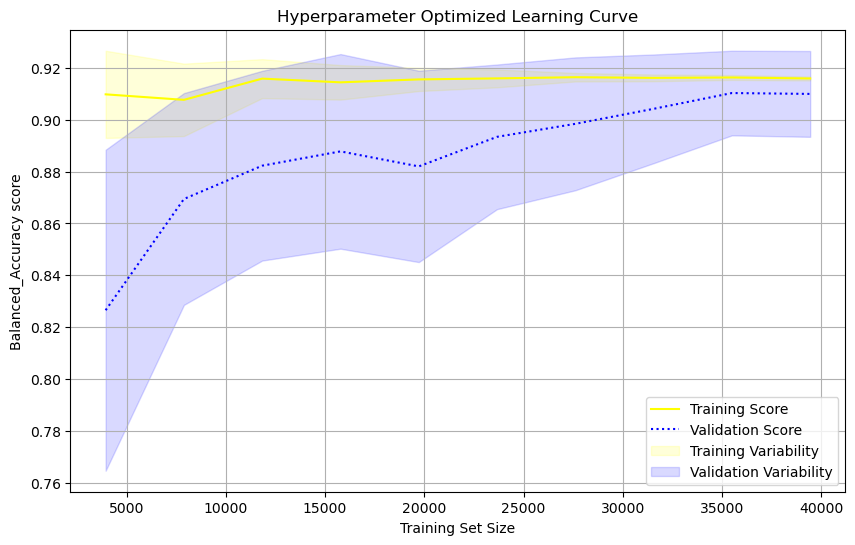

In [342]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    bayes_best_model, X, y, cv=stkf, scoring='balanced_accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', 
                            alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', 
                            alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Balanced_Accuracy score')
titel = plt.title('Hyperparameter Optimized Learning Curve')
legend = plt.legend(loc='lower right')
grid = plt.grid(True)
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The learning curve for the Bayes-optimized logistic regression model reveals that the model exhibits very good performance.   
Both the training and validation scores converge around 0.91, indicating a low level of bias in the model.   
The gap between the training and validation curves is minimal, suggesting effective regularization and almost no signs of overfitting compared to previous iterations.

While the validation scores steadily increase as more data is fed into the model, they show less variability than earlier models such as the SMOTE or weighted iterations. This decreased variance highlights the robustness of the Bayes-optimized model, likely due to the effective tuning of the hyperparameters. The training variability also diminishes with larger training set sizes, further supporting the model’s generalization ability.

When the full dataset is fed into the model the variance exhibited in the validation set appears to be minimized, at the lower level compared to the previous iterations.

While the Bayes optimization produced a balanced and high-performing model with excellent generalization capabilities and minimal variance, the improvement over the OvR iteration is marginal. This suggests that probably the logistic regression algorithm may have already reached its full potential in the context of this dataset, and further noticeable gains are unlikely.

### Model comparison

In [348]:
comparison_df = pd.concat(
    [report_df_standard, report_df_weighted, report_df_smote, report_df_ovr, report_df_bayes_grid], 
    axis=0
)
comparison_df.index = ['Standard Logreg', 'Weighted', 'SMOTE', 'OvR', 'Grid']

In [349]:
comparison_df

,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_weighted,pr_auc_weighted
Standard Logreg,0.948788,0.982952,0.965568,0.994817,0.690511,0.428830,0.529083,0.646373,1.000000,0.210526,0.347826,0.609086,0.540770,0.928055,0.965068
Weighted,0.980919,0.910603,0.944454,0.994670,0.467672,0.786945,0.586685,0.637385,0.148438,1.000000,0.258503,0.237102,0.899183,0.913447,0.963670
SMOTE,0.992168,0.842744,0.911372,0.994388,0.355166,0.919311,0.512380,0.630760,0.205128,0.842105,0.329897,0.415117,0.868054,0.877057,0.963100
OvR,0.993281,0.823701,0.900577,0.994733,0.335667,0.912965,0.490860,0.610387,0.108571,1.000000,0.195876,0.145320,0.912222,0.865185,0.961325
Grid,0.992328,0.839002,0.909247,0.994796,0.351408,0.916591,0.508040,0.612861,0.174757,0.947368,0.295082,0.285713,0.900987,0.874699,0.961802


A comparison DataFrame was generated for the records.

Given the heavily imbalanced dataset, all methods struggled to balance precision and recall, leading to a common trade-off: increasing true positives (TPs) also raised false positives (FPs), illustrating the inherent challenges of working with imbalanced data.

A practical approach for evaluating models performance would be to plot all the confusion matrices side by side and compare the TPs, FPs and so on, model by model.

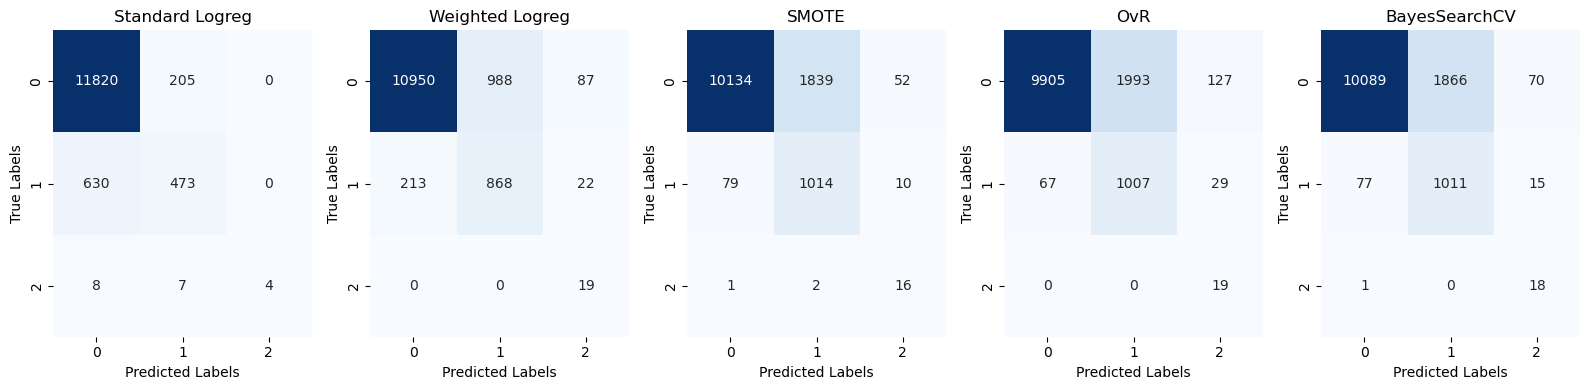

In [347]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# List of confusion matrices and method names
confusion_matrices = [conf_matrix_standard, conf_matrix_weighted, conf_matrix_smote, conf_matrix_ovr, conf_matrix_bayes_grid]
method_names = ['Standard Logreg', 'Weighted Logreg', 'SMOTE', 'OvR', 'BayesSearchCV']

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(16, 4))

for i, ax in enumerate(axes.flat):
    map = sns.heatmap(confusion_matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    title =ax.set_title(method_names[i])
    xlabel = ax.set_xlabel('Predicted Labels')
    ylabel = ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

Standard Logistic Regression, with the class imbalance intact, exhibited a strong bias toward the majority class (No Precipitation), predicting significantly more instances of it compared to other approaches. This bias resulted in poor recall for minority classes (Rain and Snowfall), with 630 and 15 false negatives (FNs), respectively.

Weighted Logistic Regression, designed to handle class imbalance, significantly reduced the FNs for the Rain class (to 213) and correctly predicted all 19 Snowfall events. However, it suffered from higher false positives (FPs) for Rain, highlighting challenges in balancing precision and recall.

SMOTE Oversampling improved recall for minority classes, particularly for Rain (~92%) by capturing 1014 true positives (TPs)—the highest among all iterations. However, this came at the expense of precision, with increased FPs for Rain (1839). Additionally, SMOTE missed 3 Snowfall instances, which the OvR iteration successfully identified.

The OvR (One-vs-Rest) iteration demonstrated the most balanced performance, achieving a solid trade-off between precision and recall. It captured 1007 Rain instances and correctly classified all 19 Snowfall events. Additionally, OvR exhibited lower variance than previous iterations, indicating better generalization.

Bayes optimization further refined the OvR model, achieving slightly better generalization and minimal variance. It captured 1011 Rain events and maintained precision for the No Precipitation class.   
However, the performance improvement over OvR was marginal, probably because the Logistic Regression algorithm has reached its performance ceiling in the context of this specific dataset.

The key takeaway from this project is that in this heavily imbalanced dataset, the OvR strategy proved to be the most effective way to differentiate between classes, achieving low bias and maintaining variance at an acceptable low level. This highlights the importance of carefully selecting the appropriate method to handle class imbalance, as it can significantly impact model performance.

### Final Thoughts

Machine Learning projects in real life conclude with actionable insights, recommendations, or real-world applications.    
However, this is not the case in this project where the primary purpose was to explore and practice various classification algorithms, such as Logistic Regression in this notebook, and their ability to handle heavily imbalanced datasets which is the most usual case in real life scenarios and present the biggest challenge.

This is also the reason why in none of the iterations did we proceed with extracting feature_importance, because drawing conclusions like "increases in relative humidity and evapotranspiration increase the likelihood of rain or decreases in temperature and dew point increase the likelihood of rain or snowfall" would be pointless and redundant in the context of this project. The emphasis was on understanding and improving model performance under challenging conditions rather than deriving domain-specific insights.

I hope you find this notebook helpful.